# Install Dependencies

In [1]:
%%capture
%pip install torch_geometric torch pandas wandb

In [5]:
import os
import shutil

# Create a directory in your Google Drive
workdir = os.getcwd() + ("/DGT")

# # Remove and recreate directory
# if os.path.exists(workdir):
#     shutil.rmtree(workdir)
# os.makedirs(workdir)

# Dataset Construction

## Download Dataset

In [3]:
# Clone the repository to download the S&P500 stock prices, precomputed correlation matrcies,
# along with trained model weights for ease of evaluation
# !git clone https://github.com/AlienKevin/sp500.git

# import shutil
# import os

# repo_name = "sp500"
# for file_name in os.listdir(repo_name):
#     shutil.move(os.path.join(repo_name, file_name), workdir)

# # Remove the cloned repository folder
# shutil.rmtree(repo_name)

## Exploratory Data Analysis Shows Superiority of Mutual Information in Capturing Interstock Relationships

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plot the 3 most correlated stocks to the target_stock based on corr_name with scope corr_scope
def plot_most_correlated_stocks(target_stock, corr_name, corr_scope):
    df = pd.read_csv(f'{workdir}/sp500.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

    target_index = df.columns.get_loc(target_stock)

    corr = np.loadtxt(f'{workdir}/{corr_name}/{corr_scope}.csv', delimiter=',')

    top_3_correlated_indices = corr[target_index].argsort()[-4:][::-1]
    top_3_correlated_stocks = df.columns[top_3_correlated_indices]

    plt.clf()
    plt.figure(figsize=(12, 6))
    plt.style.use('default')

    for stock in top_3_correlated_stocks:
        if corr_scope.startswith('global'):
            # Plot the entire duration of the dataset for global correlations
            plt.plot(df.index, df[stock], label=stock)
        else:
            # Only plot the time window corresponding to the local correlations
            num_days_in_quarter = 64
            quarter_index = int(corr_scope.split('_')[-1])
            quarter_start_index = quarter_index * num_days_in_quarter
            quarter_end_index = (quarter_index + 1) * num_days_in_quarter
            print('Quarter Start date', df.index[quarter_start_index])
            print('Quarter End date', df.index[quarter_end_index])
            quarter_df = df.iloc[quarter_start_index:quarter_end_index]
            plt.plot(quarter_df.index, quarter_df[stock], label=stock)

    plt.title(f"Top 3 Correlated Stocks with {top_3_correlated_stocks[0]} using {'Global' if corr_scope.startswith('global') else 'Local'} {'Pearson' if corr_name == 'pcc' else 'Mutual Information'}: {', '.join(top_3_correlated_stocks[1:])}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


## Global Mutual Information Captures Shared Trends Well

<Figure size 640x480 with 0 Axes>

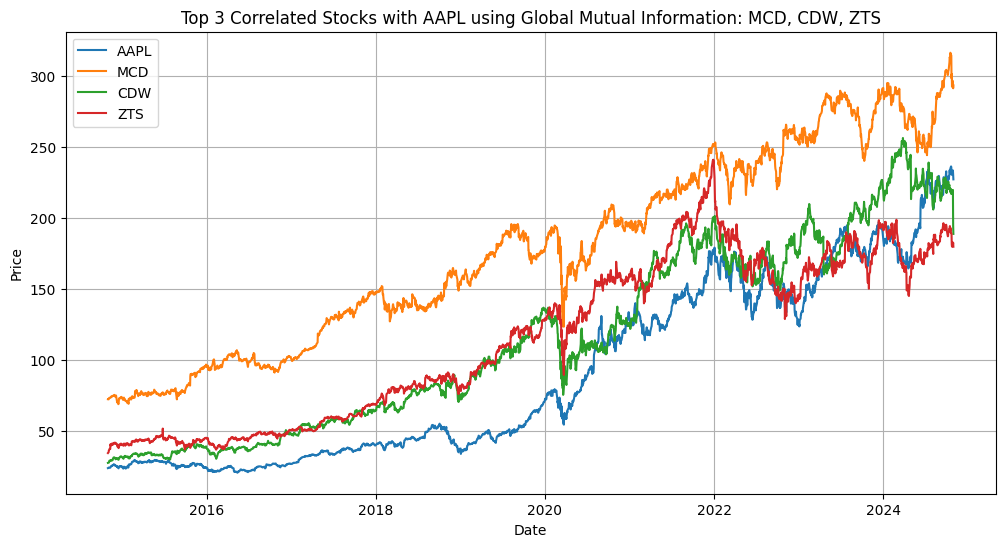

In [7]:
plot_most_correlated_stocks('AAPL', 'mi', 'global_corr')

## Global Pearson Struggles with Nonlinearity in the Market

<Figure size 640x480 with 0 Axes>

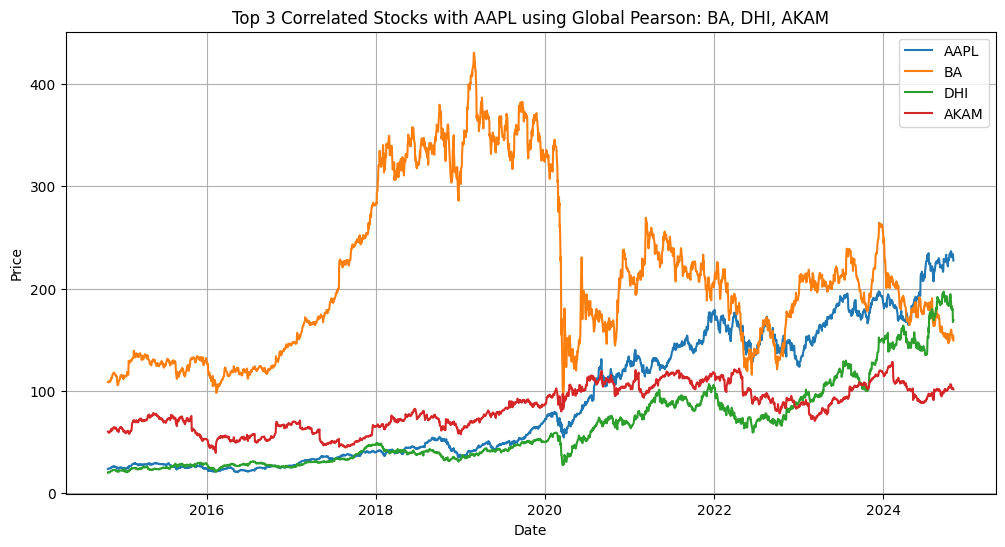

In [8]:
plot_most_correlated_stocks('AAPL', 'pcc', 'global_corr')

## Mutual Information and Pearson Perform Similarly Well on a Local Scope (the Length of 1 Fiscal Quarter)

Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00


<Figure size 640x480 with 0 Axes>

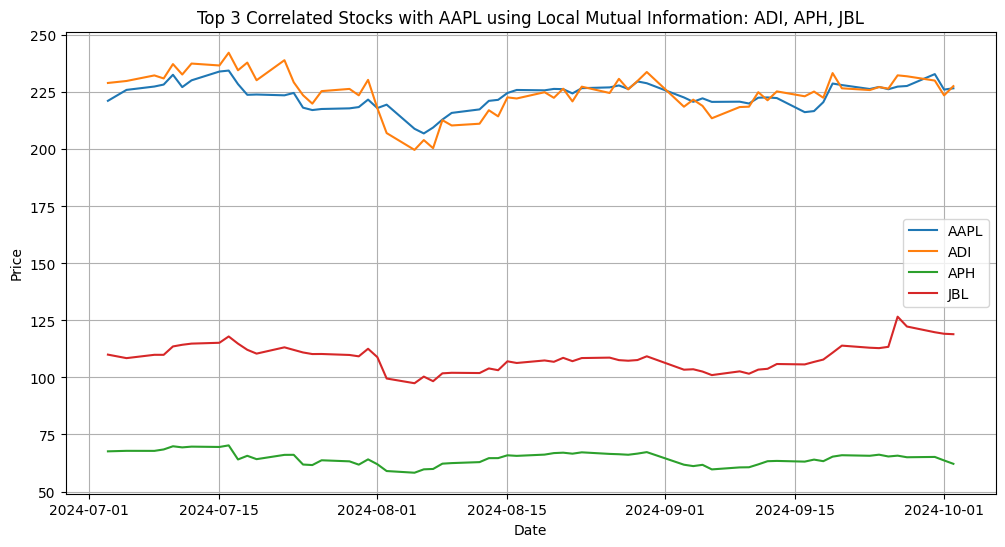

In [9]:
plot_most_correlated_stocks('AAPL', 'mi', 'local_corr_38')

Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00


<Figure size 640x480 with 0 Axes>

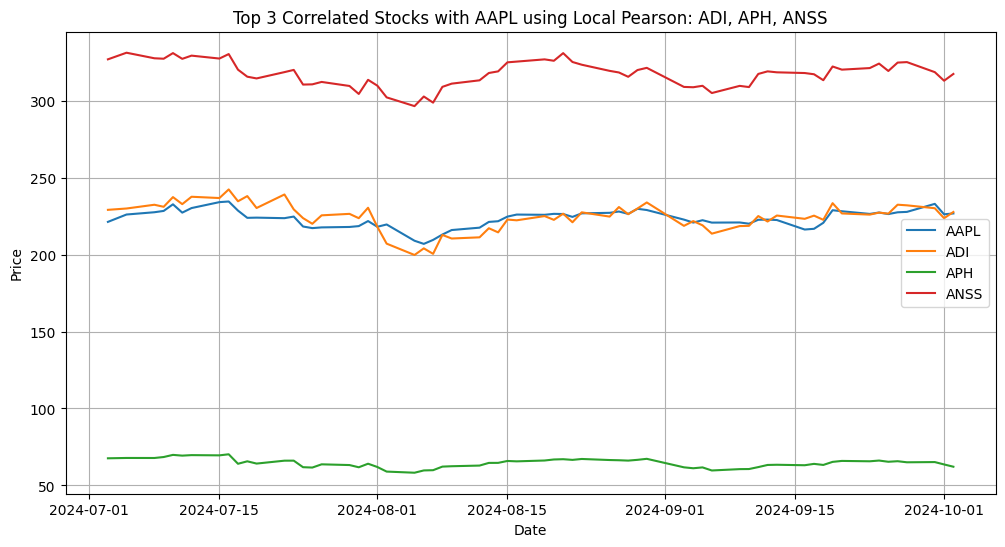

In [10]:
plot_most_correlated_stocks('AAPL', 'pcc', 'local_corr_38')

## Construct Temporal PyG Dataset

In [11]:
# Copied from PyG temporal rather than imported because the library has dependency issues with PyG
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/signal/dynamic_graph_temporal_signal.html

from typing import Sequence, Union
import numpy as np
import torch
from torch_geometric.data import Data


Edge_Indices = Sequence[Union[np.ndarray, None]]
Edge_Weights = Sequence[Union[np.ndarray, None]]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]

class DynamicGraphTemporalSignal(object):
    r"""A data iterator object to contain a dynamic graph with a
    changing edge set and weights . The feature set and node labels
    (target) are also dynamic. The iterator returns a single discrete temporal
    snapshot for a time period (e.g. day or week). This single snapshot is a
    Pytorch Geometric Data object. Between two temporal snapshots the edges,
    edge weights, target matrices and optionally passed attributes might change.

    Args:
        edge_indices (Sequence of Numpy arrays): Sequence of edge index tensors.
        edge_weights (Sequence of Numpy arrays): Sequence of edge weight tensors.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_indices: Edge_Indices,
        edge_weights: Edge_Weights,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_indices = edge_indices
        self.edge_weights = edge_weights
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        assert len(self.edge_indices) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        assert len(self.features) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self, time_index: int):
        if self.edge_indices[time_index] is None:
            return self.edge_indices[time_index]
        else:
            return torch.LongTensor(self.edge_indices[time_index])

    def _get_edge_weight(self, time_index: int):
        if self.edge_weights[time_index] is None:
            return self.edge_weights[time_index]
        else:
            return torch.FloatTensor(self.edge_weights[time_index])

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = DynamicGraphTemporalSignal(
                self.edge_indices[time_index],
                self.edge_weights[time_index],
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index(time_index)
            edge_weight = self._get_edge_weight(time_index)
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

/home/chokellaaaaaaa/epita/s9/Stock-DiffTransformer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Copied from PyG temporal rather than imported because the library has dependency issues with PyG
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/signal/static_graph_temporal_signal.html#StaticGraphTemporalSignal
import torch
import numpy as np
from typing import Sequence, Union
from torch_geometric.data import Data


Edge_Index = Union[np.ndarray, None]
Edge_Weight = Union[np.ndarray, None]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]

class StaticGraphTemporalSignal(object):
    r"""A data iterator object to contain a static graph with a dynamically
    changing constant time difference temporal feature set (multiple signals).
    The node labels (target) are also temporal. The iterator returns a single
    constant time difference temporal snapshot for a time period (e.g. day or week).
    This single temporal snapshot is a Pytorch Geometric Data object. Between two
    temporal snapshots the features and optionally passed attributes might change.
    However, the underlying graph is the same.

    Args:
        edge_index (Numpy array): Index tensor of edges.
        edge_weight (Numpy array): Edge weight tensor.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_index: Edge_Index,
        edge_weight: Edge_Weight,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self):
        if self.edge_index is None:
            return self.edge_index
        else:
            return torch.LongTensor(self.edge_index)

    def _get_edge_weight(self):
        if self.edge_weight is None:
            return self.edge_weight
        else:
            return torch.FloatTensor(self.edge_weight)

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = StaticGraphTemporalSignal(
                self.edge_index,
                self.edge_weight,
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index()
            edge_weight = self._get_edge_weight()
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

In [13]:
import numpy as np
import pandas as pd
import torch
from typing import Union
import glob
from natsort import natsorted
import random

# Fix random seed for ease of reproduction
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# Dataset loader for SP500 stock prices
class SP500CorrelationsDatasetLoader(object):
    def __init__(self, corr_name, corr_scope):
        self._read_csv(corr_name, corr_scope)

    # Load a global correlation under the name corr_name
    def _load_global_corr(self, corr_name):
        return np.loadtxt(f'{workdir}/{corr_name}/global_corr.csv', delimiter=',')

    # Load a local correlation under the name corr_name
    def _load_local_corrs(self, corr_name):
        _correlation_matrices = []
        corr_files = natsorted(glob.glob(f'{workdir}/{corr_name}/local_corr_*.csv'))
        for corr_file in corr_files:
            matrix = np.loadtxt(corr_file, delimiter=',')
            _correlation_matrices.append(matrix)
        return _correlation_matrices

    # Helper function for reading a correlation with type corr_name and scope corr_scope from CSV file
    def _read_csv(self, corr_name, corr_scope):
        match corr_scope:
            case 'global':
                self._correlation_matrices = [self._load_global_corr(corr_name)]
            case 'local':
                self._correlation_matrices = self._load_local_corrs(corr_name)
            case 'dual':
                # Stack global and local correlation matrices for dual correlation
                global_corr = self._load_global_corr(corr_name)
                self._correlation_matrices = [np.stack((global_corr, local_corr), axis=-1) for local_corr in self._load_local_corrs(corr_name)]
            case None:
                # None uses identity matrix as correlation
                # Infer dimension from a global correlation matrix
                global_corr = self._load_global_corr('pcc')
                self._correlation_matrices = [np.eye(global_corr.shape[0], global_corr.shape[1])]

        if corr_name == 'mi':
            # Normalize MI to [0, 1]
            max_mi = 0
            for matrix in self._correlation_matrices:
                max_mi = max(np.max(matrix), max_mi)
                # MI shouldn't be negative
                matrix[matrix < 0] = 0
            for matrix in self._correlation_matrices:
                matrix = matrix / max_mi

        df = pd.read_csv(f'{workdir}/sp500.csv')
        df = df.set_index('Date')
        data = torch.from_numpy(df.to_numpy()).to(torch.float32)

        # Round data size to nearest multiple of batch_size
        self.days_in_quarter = 64
        num_quarters = data.size(0) // self.days_in_quarter
        num_days = num_quarters * self.days_in_quarter
        data = data[:num_days]

        # z-score normalization with training data following GERU
        train_days = int(0.8 * num_quarters) * self.days_in_quarter
        data = (data - data[:train_days].mean(dim=0)) / data[:train_days].std(dim=0)
        data = data.numpy()

        data = data[..., np.newaxis]

        assert(not np.any(np.isnan(data)))
        self._dataset = data

    def _get_edges(self, times, overlap):
        # Construct a fully-connected graph
        def helper(corr_index):
            return np.array(np.ones(self._correlation_matrices[corr_index].shape[:2]).nonzero())

        if len(self._correlation_matrices) == 1:
            _edges = helper(0)
        else:
            _edges = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edges.append(
                    helper(corr_index)
                )
        return _edges

    def _get_edge_weights(self, times, overlap):
        # Edge weights are the correlations between stocks
        def helper(corr_index):
            w = self._correlation_matrices[corr_index]
            # Flatten the first two dimensions
            return w.reshape((w.shape[0] * w.shape[1],) + w.shape[2:])

        if len(self._correlation_matrices) == 1:
            _edge_weights = helper(0)
        else:
            _edge_weights = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edge_weights.append(
                    helper(corr_index)
                )
        return _edge_weights

    def _get_targets_and_features(self, times, overlap, predict_all):
        # Given previous batch_size stock prices...
        features = [
            self._dataset[i : i + self.batch_size, :]
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        # predict next-day stock prices
        targets = [
            (self._dataset[i+1 : i + self.batch_size+1, :, 0]).T if predict_all else (self._dataset[i + self.batch_size, :, 0]).T
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        return features, targets

    def get_dataset(self, batch_size, split) -> Union[StaticGraphTemporalSignal, DynamicGraphTemporalSignal]:
        # Returning the data iterator where the train is designed for many-to-many predictions (each day predict next day's price)
        # while the validation and test are many-to-one predictions (many past days predict tomorrow's price)

        self.batch_size = batch_size

        total_times = list(range(0, self._dataset.shape[0] - self.batch_size, self.batch_size))

        # We do a 8-1-1 split for train-validation-test. Since the test set is one year apart from training,
        # It is much more challenging to predict.
        if split == 'train':
            times = list(range(total_times[int(len(total_times) * 0)], total_times[int(len(total_times) * 0.8)]))
            overlap = self.batch_size
            predict_all = True
        elif split == 'val':
            times = list(range(total_times[int(len(total_times) * 0.8)], total_times[int(len(total_times) * 0.9)]))
            overlap = 1
            predict_all = False
        elif split == 'test':
            times = list(range(total_times[int(len(total_times) * 0.9)], total_times[-1] + self.batch_size))
            overlap = 1
            predict_all = False
        else:
            raise ValueError(f'Invalid split name: {split}')

        _edges = self._get_edges(times, overlap)
        _edge_weights = self._get_edge_weights(times, overlap)
        features, targets = self._get_targets_and_features(times, overlap, predict_all)
        dataset = (DynamicGraphTemporalSignal if type(_edges) == list else StaticGraphTemporalSignal)(
            _edges, _edge_weights, features, targets
        )
        return dataset

In [14]:
# Helper function to get the dataset for a correlation
def get_dataset(corr_name, corr_scope):
    loader = SP500CorrelationsDatasetLoader(corr_name=corr_name, corr_scope=corr_scope)

    lag_size = 64
    # Train dataset has double the batch_size because it's trained under many-to-many prediction.
    # During test time, the model is used for many-to-one prediction given batch_size previous days.
    # Hence, we need to have a larger training batch_size than the lag_size during test.
    train_dataset = loader.get_dataset(batch_size=lag_size * 2, split='train')
    val_dataset = loader.get_dataset(batch_size=lag_size, split='val')
    test_dataset = loader.get_dataset(batch_size=lag_size, split='test')

    train_samples = list(train_dataset)
    val_samples = list(val_dataset)
    test_samples = list(test_dataset)

    return {
        'train_samples': train_samples,
        'val_samples': val_samples,
        'test_samples': test_samples,
    }

# Differential Graph Transformer

In [15]:
# Adapted from reference implementation of Differential Transformer, included an optional A input to MultiheadDiffAttn.forward()
# https://github.com/microsoft/unilm/blob/master/Diff-Transformer/multihead_diffattn.py

import math
import torch
import torch.nn.functional as F
from torch import nn

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6, elementwise_affine=True):
        super().__init__()
        self.dim = dim
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(dim))
        else:
            self.register_parameter('weight', None)

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        if self.weight is not None:
            output = output * self.weight
        return output

    def extra_repr(self) -> str:
        return f'dim={self.dim}, eps={self.eps}, elementwise_affine={self.elementwise_affine}'


def init_method(tensor, **kwargs):
    nn.init.kaiming_uniform_(tensor, a=math.sqrt(5))

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=1, repeats=n_rep)"""
    bs, n_kv_heads, slen, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, None, :, :]
        .expand(bs, n_kv_heads, n_rep, slen, head_dim)
        .reshape(bs, n_kv_heads * n_rep, slen, head_dim)
    )

def lambda_init_fn(depth):
    return 0.8 - 0.6 * math.exp(-0.3 * depth)


# Differential Graph Attention with multiple heads
class MultiheadDiffAttn(nn.Module):
    def __init__(
        self,
        embed_dim,
        depth,
        num_heads,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        # num_heads set to half of Transformer's #heads
        self.num_heads = num_heads
        self.num_kv_heads = num_heads
        self.n_rep = self.num_heads // self.num_kv_heads

        self.head_dim = embed_dim // num_heads // 2
        self.scaling = self.head_dim ** -0.5

        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)

        self.lambda_init = lambda_init_fn(depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))

        self.subln = RMSNorm(2 * self.head_dim, eps=1e-5, elementwise_affine=True)

    def forward(
        self,
        x,
        A=None,
        attn_mask=None,
    ):
        bsz, tgt_len, embed_dim = x.size()
        src_len = tgt_len

        # Project input x into query, key, and value
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = q.view(bsz, tgt_len, 2 * self.num_heads, self.head_dim)
        k = k.view(bsz, src_len, 2 * self.num_kv_heads, self.head_dim)
        v = v.view(bsz, src_len, self.num_kv_heads, 2 * self.head_dim)

        q = q.transpose(1, 2)
        k = repeat_kv(k.transpose(1, 2), self.n_rep)
        v = repeat_kv(v.transpose(1, 2), self.n_rep)
        q *= self.scaling

        # Compute attention weights by multiplying query and key
        attn_weights = torch.matmul(q, k.transpose(-1, -2))
        attn_weights = torch.nan_to_num(attn_weights)
        # Apply attention mask
        if attn_mask is not None:
            attn_weights += attn_mask
        # Calculate attention scores using softmax
        attn_weights = F.softmax(attn_weights, dim=-1, dtype=torch.float32).type_as(
            attn_weights
        )

        # Calculate the lambda used for differential attention
        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(q)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(q)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init

        # Optionally condition the differential attention on a graph prior A
        attn_weights = attn_weights.view(bsz, self.num_heads, 2, tgt_len, src_len)
        attn_weights = attn_weights[:, :, 0] * (1 if A is None else A) - lambda_full * attn_weights[:, :, 1]

        # Compute output embeddings by mixing values based on their attention scores
        attn = torch.matmul(attn_weights, v)
        attn = self.subln(attn)
        attn = attn * (1 - self.lambda_init)
        attn = attn.transpose(1, 2).reshape(bsz, tgt_len, self.num_heads * 2 * self.head_dim)
        
        # Store the last attention weights for visualization
        self.last_attn = attn_weights.detach()
        
        return (attn, attn_weights)


In [16]:
import torch
import torch.nn as nn
from torch_geometric.utils import to_dense_adj

# A normal feedforward layer
class FeedForward(nn.Module):
    def __init__(self, hidden_size, expand_ratio, dropout):
        super(FeedForward, self).__init__()
        self.linear = nn.Linear(hidden_size, hidden_size * expand_ratio)
        self.linear2 = nn.Linear(hidden_size * expand_ratio, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

# Wrapper code for MultiheadDiffAttn with layer norm and feedforward after the attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, expand_ratio, dropout):
        super().__init__()
        self.mha = MultiheadDiffAttn(embed_dim=d_model, num_heads=num_heads, depth=0)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(hidden_size=d_model, expand_ratio=expand_ratio, dropout=dropout)

    def forward(self, x, A=None, attn_mask=None, need_weights=False):
        x1, attn_weights = self.mha(x, A, attn_mask=attn_mask)
        x = self.ln2(self.ffn(x1) + x1)
        if need_weights:
            return (x, attn_weights)
        else:
            return x

# Differential Graph Transformer = temporal attention + spatial attention
# Spatial attention may optionally receive an adjacency matrix for conditioning.
class DGT(nn.Module):
    def __init__(self, in_channels=1, out_channels=32, num_heads=2, num_layers=2, expand_ratio=1, dropout=0.1, T=128, N=472, use_spatial=True):
        super().__init__()
        self.T = T
        self.N = N
        self.d_model = out_channels
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.input_proj = nn.Linear(in_channels, out_channels)
        self.time_embedding = nn.Embedding(T, out_channels)
        self.stock_embedding = nn.Embedding(N, out_channels)
        self.use_spatial = use_spatial
        if use_spatial:
            self.spatial_attns = nn.ModuleList([Attention(out_channels, num_heads, expand_ratio, dropout) for _ in range(num_layers)])
        self.temporal_attns = nn.ModuleList([Attention(out_channels, num_heads, expand_ratio, dropout) for _ in range(num_layers)])

    def forward(self, x, edge_index, edge_weight, need_weights=False):
        N, T, D = x.size()
        assert(D == 1)
        assert(T <= self.T and N == self.N)

        # Compute initial node embedding for the graph transformer
        # Node embedding incorporates current stock prices, stock embeddings, and time embeddings.
        x = x.permute(1, 0, 2) # T, N, D
        x = self.input_proj(x)
        stock_embs = self.stock_embedding(torch.arange(N).unsqueeze(0).expand(T, N).to(x.device))
        x += stock_embs
        time_embs = self.time_embedding(torch.arange(T).unsqueeze(0).expand(N, T).to(x.device))
        x += time_embs.permute(1, 0, 2) # T, N, D

        x = x.permute(1, 0, 2) # N, T, D

        # Iterate through each layer of DGT
        for i in range(self.num_layers):
            # First apply temporal attention to learn temporal dependencies
            temporal_causal_mask = torch.triu(
                torch.zeros([T, T])
                    .float()
                    .fill_(float("-inf")),
                    1,
                ).expand(N, self.num_heads*2, T, T).to(x.device)
            x = self.temporal_attns[i](x, attn_mask=temporal_causal_mask, need_weights=need_weights) + x

            # Next apply spatial attention (aka differential graph attention) to learn interstock relations
            if self.use_spatial:
                x = x.permute(1, 0, 2) # T, N, D
                A = to_dense_adj(edge_index, edge_attr=edge_weight)
                # Encountered more than one adjacency matrices, e.g. dual correlations
                if len(A.size()) == 4:
                    A = A.reshape(A.size(-1), A.size(1), A.size(2))
                x = self.spatial_attns[i](x, A, need_weights=need_weights) + x
                x = x.permute(1, 0, 2) # N, T, D

        return x

# GRU Baseline

In [17]:
# Gated Recurrent Unit baseline for comparison
class GRU(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_layers: int):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(input_size=in_channels, hidden_size=out_channels, num_layers=num_layers, batch_first=True)

    def forward(
        self,
        x: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        outputs, _ = self.rnn(x)
        return outputs

# Driver

In [18]:
import torch
import torch.nn.functional as F

# Common drive for all models
class Driver(torch.nn.Module):
    def __init__(self, gnn, corr_name, corr_scope, node_features, hidden_size=32, **kwargs):
        super(Driver, self).__init__()
        self.recurrent = gnn(in_channels=node_features, out_channels=hidden_size, **kwargs)
        self.linear = torch.nn.Linear(hidden_size, 1)
        self.corr_name = corr_name
        self.corr_scope = corr_scope

    # Run on the provided graph (specified with edge_index and edge_weight) and temporal signal x (past stock prices)
    def forward(self, x, edge_index, edge_weight, hidden=None):
        device = self.model_device()
        if hidden is None:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device))
        else:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device), hidden)
        # Use final linear layer for regression
        return self.linear(F.relu(outputs)), outputs

    # Get the model name for display and saving model weights
    def model_name(self):
        arch = self.model_arch()
        if arch == 'GRU':
            return f'{arch}'
        elif arch == 'DGT':
            name = f'{arch}{"" if self.recurrent.use_spatial else "_no_spatial"}'
            if self.corr_scope is not None:
                name += f'_{self.corr_name}_{self.corr_scope}'
            return name

    # Get the model architecture for display
    def model_arch(self):
        return self.recurrent.__class__.__name__

    # Set the device for the model
    def model_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Evaluation on Price Regression with RMSE and MAE

In [19]:
import math

# Root Mean Squared Error for evaluation
def rmse(y_hat, y):
    return math.sqrt(F.mse_loss(y_hat, y).item())

# Mean Absolute Error for evaluation
def mae(y_hat, y):
    return F.l1_loss(y_hat, y).item()

In [20]:
import wandb

# Helper function for inference
def infer(model, snapshot):
    X = snapshot.x
    batch_y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr)
    return batch_y_hats[:, -1]

# Evaluate the model on eval_dataset and calculate RMSE and MAE
def eval(model, eval_dataset):
    model.eval()
    with torch.no_grad():
        y_hats = list(map(lambda snapshot: infer(model, snapshot), eval_dataset))
        ys = [snapshot.y for snapshot in eval_dataset]
        y_hats = torch.stack(y_hats, dim=0).squeeze().to(model.model_device())
        ys = torch.stack(ys, dim=0).to(model.model_device())
        eval_rmse = rmse(y_hats, ys)
        eval_mae = mae(y_hats, ys)
        return {'y_hats': y_hats, 'ys': ys, 'rmse': eval_rmse, 'mae': eval_mae}

In [21]:
# Helper function to get a model based on the input configs, optionally loads the weight if load_weights=True
def get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=False):
    node_features = 1
    if gnn == DGT:
        model = Driver(gnn, corr_name, corr_scope, node_features, num_heads=2, use_spatial=use_spatial)
    elif gnn == GRU:
        # GRU does not support any correlation
        if corr_name != None or corr_scope != None:
            return None
        model = Driver(gnn, None, None, node_features, num_layers=2)
    if load_weights:
        # Detect available device for loading weights
        if torch.cuda.is_available():
            map_location = None  # Use CUDA
        elif torch.backends.mps.is_available():
            map_location = torch.device('mps')  # Use MPS for Mac
        else:
            map_location = torch.device('cpu')  # Fallback to CPU
        model.load_state_dict(torch.load(f'{workdir}/models/{model.model_name()}_lr_{lr}.pth', weights_only=True, map_location=map_location))
    return model.to(model.model_device())

# Training

**Note: Training took 3 hours on a T4. You can skip the following code block and run the evaluations directly as our checkpoints are already downloaded.** In case you are training, you can also set `track_with_wandb` to `False` if you don't want to track with Weights and Biases.

In [22]:
import wandb
import os

# Train a model with the input configs on train_samples for num_epochs under the learning rate lr
# You can pass track_with_wandb=True to trace the entire training process with Weights and Biases
def train(gnn, use_spatial, corr_name, corr_scope, train_samples, val_samples, num_epochs, lr, track_with_wandb):
    os.makedirs(f'{workdir}/models', exist_ok=True)

    model = get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_rmse = float('inf')
    best_val_mae = float('inf')
    eval_per_epoch = 10

    if track_with_wandb:
        wandb_run = wandb.init(project="cs224w-stock-market-prediction",
                   name=f'{model.model_name()}_lr_{lr}',
                   config={
                       "corr_name": corr_name,
                       "corr_scope": corr_scope,
                       "learning_rate": lr,
                       "epochs": num_epochs,
                       "architecture": gnn.__name__,
                       "use_spatial": use_spatial,
                   },
                   reinit=True,
                   )

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, snapshot in enumerate(train_samples):
            optimizer.zero_grad()
            X = snapshot.x
            y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr, hidden=None)
            loss = F.mse_loss(y_hats.squeeze(), snapshot.y.to(model.model_device()))
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            if track_with_wandb:
                wandb.log({"epoch": epoch, "step": step, "train/loss": loss.item() })
        train_loss /= len(train_samples)

        if epoch % eval_per_epoch == 0 or epoch == num_epochs - 1:
            result = eval(model, val_samples)
            val_rmse = result['rmse']
            val_mae = result['mae']
            print(f'{model.model_name()} epoch {epoch} val/rmse: {val_rmse} val/mae: {val_mae}')
            if track_with_wandb:
                wandb.log({"epoch": epoch, "val/rmse": val_rmse, "val/mae": val_mae })
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_val_mae = val_mae
                torch.save(model.state_dict(), f'{workdir}/models/{model.model_name()}_lr_{lr}.pth')
    if track_with_wandb:
        wandb.log({"val/best_rmse": best_val_rmse, "val/best_mae": best_val_mae })
        return wandb_run


def run(args):
    config, num_epochs, track_with_wandb = args
    gnn, use_spatial, corr_name, corr_scope = config
    dataset = get_dataset(corr_name, corr_scope)
    # Do a grid search over learning rate. We found that models are sensitive to lr so we need to try different options.
    for lr in [0.01, 0.1]:
        wandb_run = train(gnn, use_spatial, corr_name, corr_scope, dataset['train_samples'], dataset['val_samples'], num_epochs, lr, track_with_wandb)
        # Test
        best_model = get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=True)
        result = eval(best_model, dataset['test_samples'])
        test_rmse = result['rmse']
        test_mae = result['mae']
        print(f'{best_model.model_name()} lr: {lr} test/rmse: {test_rmse} test/mae: {test_mae}')
        if track_with_wandb:
            wandb.log({"test/rmse": test_rmse, "test/mae": test_mae })
            wandb_run.finish()

# List all the model variants for the experiment
model_configs = [(GRU, False, None, None),
                 (DGT, False, None, None),
                 (DGT, True, None, None),
                 (DGT, True, 'mi', 'global'),
                 (DGT, True, 'mi', 'local'),
                 (DGT, True, 'mi', 'dual'),
                 (DGT, True, 'pcc', 'global'),
                 (DGT, True, 'pcc', 'local'),
                 (DGT, True, 'pcc', 'dual'),
                 ]

# num_epochs = 100
# track_with_wandb = True

# if track_with_wandb:
#     wandb.login()

# _ = list(map(run, [(config, num_epochs, track_with_wandb) for config in model_configs]))

# Results Show Local Mutual Information Performs the Best, Followed by Dual Pearson

In [23]:
# Function to test a bunch of models given by model_configs on the test set
def test(model_configs):
    results = {}
    for config in model_configs:
        (gnn, use_spatial, corr_name, corr_scope, lr) = config
        eval_dataset = get_dataset(corr_name, corr_scope)['test_samples']
        model = get_model(gnn, use_spatial, corr_name, corr_scope, lr=lr, load_weights=True)
        if model is None:
            continue
        results[config] = eval(model=model, eval_dataset=eval_dataset)
    return results

# Test each model under its best learning rate based on validation performance
model_configs = [(GRU, False, None, None, 0.01),
                 (DGT, False, None, None, 0.1),
                 (DGT, True, None, None, 0.01),
                 (DGT, True, 'mi', 'global', 0.01),
                 (DGT, True, 'mi', 'local', 0.01),
                 (DGT, True, 'mi', 'dual', 0.01),
                 (DGT, True, 'pcc', 'global', 0.01),
                 (DGT, True, 'pcc', 'local', 0.01),
                 (DGT, True, 'pcc', 'dual', 0.01),
                 ]
test_results = test(model_configs)

In [24]:
# Test the models and show a table of results
test_results_df = []
for config, result in test_results.items():
    (arch, use_spatial, corr_name, corr_scope, lr) = config
    test_results_df.append({'Architecture': arch.__name__,
                            'Use Spatial': use_spatial,
                            'Correlation': corr_name,
                            'Scope': corr_scope,
                            'RMSE': result['rmse'],
                            'MAE': result['mae']})

test_results_df = pd.DataFrame(test_results_df)
test_results_df = test_results_df.sort_values(by='RMSE', ascending=False)
print('Test results sorted in descending RMSE (Lower the better)')
display(test_results_df)

Test results sorted in descending RMSE (Lower the better)


,Architecture,Use Spatial,Correlation,Scope,RMSE,MAE
0,GRU,False,None,None,3.116608,0.407619
2,DGT,True,None,None,1.473705,0.292516
6,DGT,True,pcc,global,0.643023,0.147955
3,DGT,True,mi,global,0.465103,0.114918
1,DGT,False,None,None,0.432899,0.181658
4,DGT,True,mi,local,0.324191,0.133980
8,DGT,True,pcc,dual,0.296782,0.157395
7,DGT,True,pcc,local,0.294103,0.086751
5,DGT,True,mi,dual,0.259889,0.099287


# Visualize Results

In [25]:
df = pd.read_csv(f'{workdir}/sp500.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
stock_names = df.columns
stock_lookup = {name: i for i, name in enumerate(stock_names)}

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler

# Plot regression results on test set
def plot_regression(configs, labels, fig_name, stock_name, test_results):
    stock_index = stock_lookup[stock_name]
    plt.clf()
    plt.figure(figsize=(10, 6))
    colors = [(0.650, 0.120, 0.240, 0.6),  # red
              (0.122, 0.467, 0.706, 0.6), # blue
              (1.000, 0.498, 0.055), # orange
              (0.580, 0.403, 0.741, 0.6), # purple
              ]
    plt.rc('axes', prop_cycle=cycler('color', colors))

    for config, label in zip(configs, labels):
        result = test_results[config]
        ys = torch.tensor([y[stock_index] for y in result['ys'].cpu()])
        y_hats = torch.tensor([y_hat[stock_index] for y_hat in result['y_hats'].cpu()])
        x = np.array(range(len(ys)))
        plt.plot(x, y_hats, label=label, linewidth=1)

    plt.plot(x, ys, label="Real", color='green')
    plt.legend(fontsize=14)
    plt.title(f'Predicted vs Real {stock_name} Stock Price on Test', fontsize=20)
    plt.xlabel('Days', fontsize=16)
    plt.ylabel('Normalized Price', fontsize=16)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
    plt.savefig(fig_name)
    plt.show()


## Local Mutual Information Outperforms Global and Dual

<Figure size 640x480 with 0 Axes>

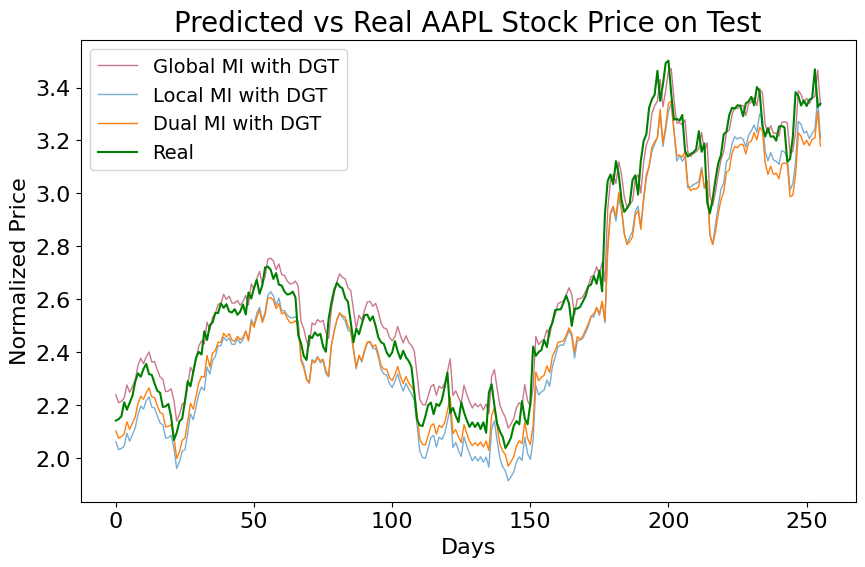

In [27]:
plot_regression([(DGT, True, 'mi', 'global', 0.01),
                (DGT, True, 'mi', 'local', 0.01),
                (DGT, True, 'mi', 'dual', 0.01)
                ],
                ['Global MI with DGT', 'Local MI with DGT', 'Dual MI with DGT'],
                stock_name='AAPL', fig_name=f'{workdir}/sp500_AAPL_MI.png', test_results=test_results)

## Dual Pearson Outperforms Global and Local

<Figure size 640x480 with 0 Axes>

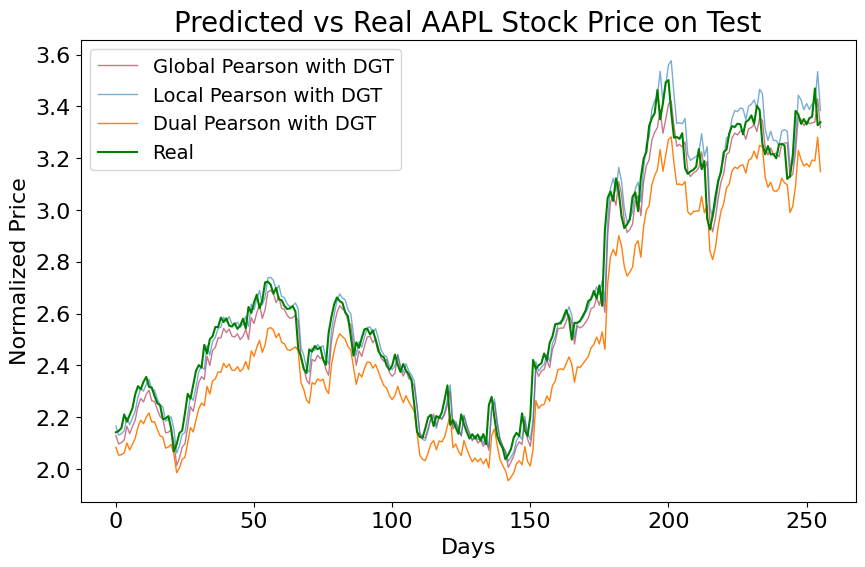

In [28]:
plot_regression([(DGT, True, 'pcc', 'global', 0.01),
                (DGT, True, 'pcc', 'local', 0.01),
                (DGT, True, 'pcc', 'dual', 0.01)],
                ['Global Pearson with DGT', 'Local Pearson with DGT', 'Dual Pearson with DGT'],
                stock_name='AAPL', fig_name=f'{workdir}/sp500_AAPL_PCC.png', test_results=test_results)

# Extension Multi-Tâche : Prédiction de la Volatilité pour le Risk Management

Dans cette section, nous étendons le modèle DGT pour prédire simultanément :
- **α (alpha)** : le prix du lendemain (tâche existante)
- **σ (sigma)** : la volatilité future sur un horizon H jours (nouvelle tâche)

Cette extension permet d'intégrer explicitement le risque dans les décisions d'allocation de portefeuille, en utilisant une volatilité **prédictive** (ex-ante) plutôt que réactive (historique).

## Définitions Mathématiques

$$
r_{t}=\ln\left(\frac{P_t}{P_{t-1}}\right),\quad
\sigma_{t}^{(H)}=\operatorname{Std}\left(r_{t+1},\dots,r_{t+H}\right)
$$

Le modèle apprend à prédire $\sigma^{(H)}$ en exploitant les dépendances inter-actifs capturées par le graphe.

## Dataset Multi-Tâche (Prix + Volatilité Future)

Nous créons un nouveau loader qui produit une cible à 2 dimensions :
- `y[..., 0]` = prix à t+1 (alpha)
- `y[..., 1]` = volatilité future sur horizon H (sigma)

In [66]:
import numpy as np

class MultiTaskSP500DatasetLoader(SP500CorrelationsDatasetLoader):
    """
    Loader multi-tâche :
      - y[..., 0] = alpha (prix à t+1)
      - y[..., 1] = sigma (volatilité future sur horizon H)
    """

    def __init__(self, corr_name, corr_scope, vol_horizon=5):
        super().__init__(corr_name=corr_name, corr_scope=corr_scope)
        self.vol_horizon = int(vol_horizon)

    @staticmethod
    def _future_vol_from_prices(prices_2d: np.ndarray) -> np.ndarray:
        """
        Calcule la volatilité future à partir des prix.
        prices_2d : (H+1, N) avec [P_t, ..., P_{t+H}]
        Rendements = différences (P_t - P_{t-1})
        """
        rets = np.diff(prices_2d, axis=0)  # (H, N)
        sigma = np.std(rets, axis=0)        # (N,)
        return sigma

    def get_dataset(self, batch_size, split):
        self.batch_size = batch_size
        T = self._dataset.shape[0]
        B = self.batch_size
        H = self.vol_horizon

        total_times = list(range(0, T - B, B))

        if split == "train":
            times = total_times[: int(0.8 * len(total_times))]
            overlap = B
            predict_all = True
        elif split == "val":
            times = total_times[int(0.8 * len(total_times)) : int(0.9 * len(total_times))]
            overlap = 1
            predict_all = False
        elif split == "test":
            times = total_times[int(0.9 * len(total_times)) :]
            overlap = 1
            predict_all = False
        else:
            raise ValueError("split invalide")

        # S'assurer qu'on peut calculer la volatilité future
        max_start = T - B - H
        times = [t for t in times if t <= max_start]

        edges = self._get_edges(times, overlap)
        edge_weights = self._get_edge_weights(times, overlap)
        features, targets = self._get_targets_and_features(times, overlap, predict_all)

        dataset = (DynamicGraphTemporalSignal if isinstance(edges, list) else StaticGraphTemporalSignal)(
            edges, edge_weights, features, targets
        )
        return dataset

    def _get_targets_and_features(self, times, overlap, predict_all):
        T = self._dataset.shape[0]
        B = self.batch_size
        H = self.vol_horizon

        features, targets = [], []

        for i in range(0, T - B, overlap):
            if i not in times:
                continue

            X = self._dataset[i : i + B, :]
            features.append(X)

            if predict_all:
                # Many-to-many: prédire chaque jour
                y_alpha = self._dataset[i + 1 : i + B + 1, :, 0].T
                sigmas = []
                for j in range(B):
                    t = i + j
                    prices_slice = self._dataset[t : t + H + 1, :, 0]
                    sigmas.append(self._future_vol_from_prices(prices_slice))
                y_sigma = np.stack(sigmas, axis=0).T
                y = np.stack([y_alpha, y_sigma], axis=-1)
            else:
                # Many-to-one: prédire le dernier jour
                y_alpha = self._dataset[i + B, :, 0].T
                t = i + B - 1
                prices_slice = self._dataset[t : t + H + 1, :, 0]
                y_sigma = self._future_vol_from_prices(prices_slice)
                y = np.stack([y_alpha, y_sigma], axis=-1)

            targets.append(y)

        return features, targets


def get_multitask_dataset(corr_name, corr_scope, vol_horizon=5):
    """
    Version multi-tâche du helper get_dataset.
    Retourne un dict avec train_samples / val_samples / test_samples.
    """
    loader = MultiTaskSP500DatasetLoader(
        corr_name=corr_name,
        corr_scope=corr_scope,
        vol_horizon=vol_horizon,
    )

    lag_size = 64
    train_dataset = loader.get_dataset(batch_size=lag_size * 2, split="train")
    val_dataset = loader.get_dataset(batch_size=lag_size, split="val")
    test_dataset = loader.get_dataset(batch_size=lag_size, split="test")

    return {
        "train_samples": list(train_dataset),
        "val_samples": list(val_dataset),
        "test_samples": list(test_dataset),
    }

In [67]:
# Configuration : utiliser la meilleure configuration (Dual PCC)
corr_name = 'pcc'
corr_scope = 'dual'
vol_horizon = 20

# Charger le dataset multi-tâche
mt_data = get_multitask_dataset(corr_name=corr_name, corr_scope=corr_scope, vol_horizon=vol_horizon)

train_samples_mt = mt_data["train_samples"]
val_samples_mt = mt_data["val_samples"]
test_samples_mt = mt_data["test_samples"]

print(f"Dataset multi-tâche chargé avec corrélation {corr_name} {corr_scope}")
print(f"Nb train/val/test: {len(train_samples_mt)}, {len(val_samples_mt)}, {len(test_samples_mt)}")
print(f"Shape y (train sample 0): {train_samples_mt[0].y.shape}")
print(f"Shape y (val sample 0): {val_samples_mt[0].y.shape}")
print(f"Shape y (test sample 0): {test_samples_mt[0].y.shape}")

Dataset multi-tâche chargé avec corrélation pcc dual
Nb train/val/test: 15, 4, 4
Shape y (train sample 0): torch.Size([472, 128, 2])
Shape y (val sample 0): torch.Size([472, 2])
Shape y (test sample 0): torch.Size([472, 2])


## Modèle Multi-Tête (Alpha + Sigma)

Nous créons un `MultiTaskDriver` avec deux têtes de sortie :
- **Tête Alpha** : prédiction du prix (régression linéaire)
- **Tête Sigma** : prédiction de la volatilité future (contrainte positive via Softplus)

In [68]:
import torch.nn as nn

class MultiTaskDriver(Driver):
    """
    Driver multi-tâche :
      - y_hats[..., 0] = alpha (prix)
      - y_hats[..., 1] = sigma (volatilité future, positive)
    """
    def __init__(self, gnn, corr_name, corr_scope, node_features, hidden_size=32, **kwargs):
        super().__init__(gnn, corr_name, corr_scope, node_features, hidden_size=hidden_size, **kwargs)
        
        # Deux têtes de sortie
        self.alpha_head = nn.Linear(hidden_size, 1)
        self.sigma_head = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Softplus()  # sigma >= 0
        )

    def forward(self, x, edge_index, edge_weight, hidden=None):
        device = self.model_device()
        
        if hidden is None:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device))
        else:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device), hidden)

        h = F.relu(outputs)  # (N, T, hidden_size)

        alpha_hat = self.alpha_head(h)  # (N, T, 1)
        sigma_hat = self.sigma_head(h)  # (N, T, 1) positif

        y_hats = torch.cat([alpha_hat, sigma_hat], dim=-1)  # (N, T, 2)
        return y_hats, outputs


def get_multitask_model(gnn, use_spatial, corr_name, corr_scope, lr=0.01, load_weights=False, hidden_size=32):
    """
    Construit un MultiTaskDriver.
    """
    node_features = 1

    if gnn == DGT:
        model = MultiTaskDriver(
            gnn, corr_name, corr_scope, node_features,
            hidden_size=hidden_size,
            num_heads=2,
            use_spatial=use_spatial
        )
    elif gnn == GRU:
        if corr_name is not None or corr_scope is not None:
            return None
        model = MultiTaskDriver(
            gnn, None, None, node_features,
            hidden_size=hidden_size,
            num_layers=2
        )
    else:
        raise ValueError("GNN non supporté")

    if load_weights:
        if torch.cuda.is_available():
            map_location = None
        elif torch.backends.mps.is_available():
            map_location = torch.device("mps")
        else:
            map_location = torch.device("cpu")

        model.load_state_dict(
            torch.load(f"models/multitask_{model.model_name()}_lr_{lr}.pt",
                       weights_only=True, map_location=map_location)
        )

    return model.to(model.model_device())

In [69]:
# Créer le modèle multi-tâche
multitask_model = get_multitask_model(
    gnn=DGT,
    use_spatial=True,
    corr_name=corr_name,
    corr_scope=corr_scope,
    lr=0.01,
    load_weights=False,
    hidden_size=32
)

# Test forward pass
sample = val_samples_mt[0]
x_ntd = sample.x.transpose(0, 1)  # (N, T, D)
y_hats, _ = multitask_model(x_ntd, sample.edge_index, sample.edge_attr)

print(f"Modèle créé: {multitask_model.model_name()}")
print(f"Shape sortie y_hats: {y_hats.shape}")
print(f"Alpha last step: shape={y_hats[:, -1, 0].shape}")
print(f"Sigma last step: min={y_hats[:, -1, 1].min():.4f}, max={y_hats[:, -1, 1].max():.4f}")

Modèle créé: DGT_pcc_dual
Shape sortie y_hats: torch.Size([472, 64, 2])
Alpha last step: shape=torch.Size([472])
Sigma last step: min=0.0723, max=2.1166


## Entraînement Multi-Tâche

Loss multi-tâche avec pondération :

$$
\mathcal{L} = \mathrm{MSE}(\hat{\alpha}, \alpha) + \lambda \cdot \mathrm{MSE}(\hat{\sigma}, \sigma)
$$

In [70]:
import os
import math

def pick_device():
    """Priorité : CUDA > MPS > CPU."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

def multitask_loss(y_hat, y_true, lam_sigma=1.0):
    """
    y_hat : (N, T, 2) ou (N, 2)
    y_true: (N, T, 2) ou (N, 2)
    """
    mse = nn.MSELoss()
    loss_alpha = mse(y_hat[..., 0], y_true[..., 0])
    loss_sigma = mse(y_hat[..., 1], y_true[..., 1])
    total_loss = loss_alpha + lam_sigma * loss_sigma
    return total_loss, loss_alpha.detach(), loss_sigma.detach()

def select_last_if_needed(y_hat, y_true):
    """Si y_true est (N,2) et y_hat est (N,T,2), prendre le dernier pas de temps."""
    if y_true.ndim == 2 and y_hat.ndim == 3:
        return y_hat[:, -1, :], y_true
    return y_hat, y_true

@torch.no_grad()
def eval_multitask(driver, samples, lam_sigma=1.0, device=None):
    """Évaluation sur un dataset."""
    driver.eval()
    if device is None:
        device = pick_device()
    driver.to(device)

    total_loss, total_alpha, total_sigma = 0.0, 0.0, 0.0
    n = 0

    for s in samples:
        x_ntd = s.x.transpose(0, 1)
        y_hat, _ = driver(x_ntd, s.edge_index, s.edge_attr)
        y_true = s.y.to(device)
        y_hat, y_true = select_last_if_needed(y_hat, y_true)
        loss, la, ls = multitask_loss(y_hat, y_true, lam_sigma=lam_sigma)

        total_loss += float(loss.item())
        total_alpha += float(la.item())
        total_sigma += float(ls.item())
        n += 1

    if n == 0:
        return math.nan, math.nan, math.nan
    return total_loss / n, total_alpha / n, total_sigma / n

In [71]:
def train_multitask(
    driver,
    train_samples,
    val_samples,
    epochs=30,
    lr=1e-3,
    weight_decay=0.0,
    lam_sigma=1.0,
    patience=5,
    ckpt_path="models/multitask_dgt_best.pt",
    resume_if_exists=True,
):
    """
    Entraînement multi-tâche avec early stopping.
    """
    device = pick_device()
    driver.to(device)
    
    os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)

    # Reprise si checkpoint existant
    if resume_if_exists and os.path.exists(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
        driver.load_state_dict(ckpt["model_state"])
        print(f"✅ Checkpoint rechargé: {ckpt_path}")
        print(f"   Best epoch: {ckpt['best_epoch']} | Best val loss: {ckpt['best_val_loss']:.6f}")
        return {"loaded": True, "ckpt": ckpt, "device": str(device), "ckpt_path": ckpt_path}

    optimizer = torch.optim.AdamW(driver.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_val = float("inf")
    best_epoch = -1
    wait = 0
    
    history = {
        "train_loss": [], "train_alpha": [], "train_sigma": [],
        "val_loss": [], "val_alpha": [], "val_sigma": [],
    }

    print(f"Entraînement sur {device}...")
    
    for epoch in range(1, epochs + 1):
        driver.train()
        sum_loss, sum_alpha, sum_sigma, n = 0.0, 0.0, 0.0, 0

        for s in train_samples:
            optimizer.zero_grad(set_to_none=True)
            x_ntd = s.x.transpose(0, 1)
            
            y_hat, _ = driver(x_ntd, s.edge_index, s.edge_attr)
            y_true = s.y.to(device)
            y_hat, y_true = select_last_if_needed(y_hat, y_true)
            loss, la, ls = multitask_loss(y_hat, y_true, lam_sigma=lam_sigma)

            loss.backward()
            optimizer.step()

            sum_loss += float(loss.item())
            sum_alpha += float(la.item())
            sum_sigma += float(ls.item())
            n += 1

        train_loss = sum_loss / max(n, 1)
        train_alpha = sum_alpha / max(n, 1)
        train_sigma = sum_sigma / max(n, 1)

        val_loss, val_alpha, val_sigma = eval_multitask(driver, val_samples, lam_sigma=lam_sigma, device=device)

        history["train_loss"].append(train_loss)
        history["train_alpha"].append(train_alpha)
        history["train_sigma"].append(train_sigma)
        history["val_loss"].append(val_loss)
        history["val_alpha"].append(val_alpha)
        history["val_sigma"].append(val_sigma)

        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train={train_loss:.5f} (α={train_alpha:.5f}, σ={train_sigma:.5f}) | "
              f"val={val_loss:.5f} (α={val_alpha:.5f}, σ={val_sigma:.5f})")

        # Sauvegarde + early stopping
        if val_loss < best_val:
            best_val = val_loss
            best_epoch = epoch
            wait = 0
            ckpt = {
                "model_state": driver.state_dict(),
                "best_val_loss": float(best_val),
                "best_epoch": int(best_epoch),
                "history": history,
            }
            torch.save(ckpt, ckpt_path)
        else:
            wait += 1
            if wait >= patience:
                print(f"⏹️ Early stopping à epoch {epoch} | Best: epoch {best_epoch}, val={best_val:.6f}")
                break

    # Recharger le meilleur modèle
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    driver.load_state_dict(ckpt["model_state"])

    return {
        "loaded": False,
        "device": str(device),
        "best_val_loss": best_val,
        "best_epoch": best_epoch,
        "history": history,
        "ckpt_path": ckpt_path,
    }

In [72]:
# Lancer l'entraînement (ou charger le checkpoint s'il existe)
train_result = train_multitask(
    driver=multitask_model,
    train_samples=train_samples_mt,
    val_samples=val_samples_mt,
    epochs=30,
    lr=1e-3,
    weight_decay=0.0,
    lam_sigma=1.0,
    patience=5,
    ckpt_path="models/multitask_dgt_best_20.pt",
    resume_if_exists=True,
)

print(f"\n📊 Résultat: Device={train_result['device']}, Loaded={train_result.get('loaded', False)}")
print(f"   Checkpoint: {train_result.get('ckpt_path')}")

Entraînement sur cuda...
Epoch 01/30 | train=0.78411 (α=0.58852, σ=0.19558) | val=1.26425 (α=1.24322, σ=0.02103)
Epoch 02/30 | train=0.49969 (α=0.48598, σ=0.01371) | val=0.97549 (α=0.96778, σ=0.00771)
Epoch 03/30 | train=0.28147 (α=0.27295, σ=0.00852) | val=0.86152 (α=0.85601, σ=0.00551)
Epoch 04/30 | train=0.26629 (α=0.25948, σ=0.00681) | val=0.62414 (α=0.61909, σ=0.00504)
Epoch 05/30 | train=0.20699 (α=0.20126, σ=0.00572) | val=0.59275 (α=0.58825, σ=0.00449)
Epoch 06/30 | train=0.19387 (α=0.18890, σ=0.00497) | val=0.47452 (α=0.47030, σ=0.00421)
Epoch 07/30 | train=0.17090 (α=0.16647, σ=0.00443) | val=0.47454 (α=0.47048, σ=0.00406)
Epoch 08/30 | train=0.15154 (α=0.14748, σ=0.00405) | val=0.44475 (α=0.44079, σ=0.00396)
Epoch 09/30 | train=0.13684 (α=0.13309, σ=0.00375) | val=0.41262 (α=0.40873, σ=0.00389)
Epoch 10/30 | train=0.12727 (α=0.12373, σ=0.00354) | val=0.39016 (α=0.38629, σ=0.00387)
Epoch 11/30 | train=0.11955 (α=0.11614, σ=0.00341) | val=0.37792 (α=0.37405, σ=0.00387)
Epoch 1

## Extraction des Prédictions sur le Test Set

Nous extrayons les prédictions de prix (α) et de volatilité (σ) sur le jeu de test pour les analyses suivantes.

In [73]:
@torch.no_grad()
def extract_predictions(driver, samples, device=None):
    """Extrait alpha_pred, sigma_pred, alpha_true, sigma_true pour chaque snapshot."""
    driver.eval()
    if device is None:
        device = pick_device()
    driver.to(device)
    
    alpha_pred_list = []
    sigma_pred_list = []
    alpha_true_list = []
    sigma_true_list = []
    
    for s in samples:
        x_ntd = s.x.transpose(0, 1)
        y_hat, _ = driver(x_ntd, s.edge_index, s.edge_attr)
        y_true = s.y.to(device)
        y_hat, y_true = select_last_if_needed(y_hat, y_true)
        
        alpha_pred_list.append(y_hat[:, 0].cpu())
        sigma_pred_list.append(y_hat[:, 1].cpu())
        alpha_true_list.append(y_true[:, 0].cpu())
        sigma_true_list.append(y_true[:, 1].cpu())
    
    return {
        "alpha_pred": alpha_pred_list,
        "sigma_pred": sigma_pred_list,
        "alpha_true": alpha_true_list,
        "sigma_true": sigma_true_list,
    }

# Extraire les prédictions sur le test set
test_predictions = extract_predictions(multitask_model, test_samples_mt)

print(f"Nb snapshots test: {len(test_predictions['alpha_pred'])}")
print(f"Shape alpha_pred[0]: {test_predictions['alpha_pred'][0].shape}")
print(f"Sigma prédite [0]: min={test_predictions['sigma_pred'][0].min():.4f}, max={test_predictions['sigma_pred'][0].max():.4f}")
print(f"Sigma vraie [0]: min={test_predictions['sigma_true'][0].min():.4f}, max={test_predictions['sigma_true'][0].max():.4f}")

Nb snapshots test: 4
Shape alpha_pred[0]: torch.Size([472])
Sigma prédite [0]: min=0.0000, max=0.2710
Sigma vraie [0]: min=0.0112, max=1.2501


# Risk Management avec Volatilité Prédictive

Cette section exploite la volatilité prédite par le GNN ($\hat{\sigma}$) pour construire un portefeuille avec gestion du risque intégrée.

## Approche

1. **Volatilité historique** (baseline) : $\sigma_{hist}$ calculée sur une fenêtre glissante des rendements passés
2. **Volatilité prédictive** (GNN) : $\hat{\sigma}$ apprise par le modèle multi-tâche

L'allocation inverse-risque pondère chaque actif selon :

$$
w_i \propto \frac{1}{\sigma_i}
$$

## Calcul de la Volatilité Historique (Baseline)

In [74]:
def compute_historical_volatility(samples, window=60):
    """
    Calcule la volatilité historique pour chaque snapshot.
    Rendements = différences (P_t - P_{t-1}) sur prix normalisés.
    """
    sigma_hist_list = []

    for s in samples:
        prices = s.x.squeeze(-1).cpu().numpy()  # (T, N)
        rets = np.diff(prices, axis=0)           # (T-1, N)

        if rets.shape[0] == 0:
            sigma = np.zeros(prices.shape[1], dtype=np.float32)
        elif rets.shape[0] < window:
            sigma = np.std(rets, axis=0)
        else:
            sigma = np.std(rets[-window:], axis=0)

        sigma = np.nan_to_num(sigma, nan=0.0, posinf=0.0, neginf=0.0)
        sigma_hist_list.append(torch.tensor(sigma, dtype=torch.float32))

    return sigma_hist_list

# Calculer la volatilité historique pour le test set
sigma_hist_test = compute_historical_volatility(test_samples_mt, window=60)
sigma_pred_test = test_predictions['sigma_pred']

print(f"Nb snapshots: {len(sigma_hist_test)}")
print(f"σ_hist[0]: min={sigma_hist_test[0].min():.4f}, max={sigma_hist_test[0].max():.4f}")
print(f"σ_pred[0]: min={sigma_pred_test[0].min():.4f}, max={sigma_pred_test[0].max():.4f}")

Nb snapshots: 4
σ_hist[0]: min=0.0095, max=1.5332
σ_pred[0]: min=0.0000, max=0.2710


## Fonctions d'Allocation de Portefeuille

In [75]:
def inverse_risk_allocation(sigma, w_max=0.05, eps=1e-6):
    """
    Allocation inverse-risque : w_i ∝ 1/σ_i
    Args:
        sigma: Tensor (N,) volatilité par actif
        w_max: poids maximum par actif (pour éviter la concentration)
    Returns:
        weights: Tensor (N,), somme = 1
    """
    raw = 1.0 / (sigma + eps)
    w = raw / raw.sum()
    w = torch.clamp(w, max=w_max)
    w = w / w.sum()
    return w

def hybrid_allocation(sigma_hist, sigma_pred, lam=1.0, w_max=0.05, eps=1e-6):
    """
    Allocation hybride : pondère par σ_hist et pénalise par σ_pred (GNN).
    w_i ∝ 1/(σ_hist_i + eps) × 1/(1 + λ × σ_pred_i)
    """
    base = 1.0 / (sigma_hist + eps)
    penalty = 1.0 / (1.0 + lam * sigma_pred)
    raw = base * penalty
    w = raw / raw.sum()
    w = torch.clamp(w, max=w_max)
    w = w / w.sum()
    return w

def realized_portfolio_volatility(sample, weights):
    """
    Calcule la volatilité réalisée du portefeuille sur un snapshot.
    """
    prices = sample.x.squeeze(-1)           # (T, N)
    rets = prices[1:] - prices[:-1]         # (T-1, N)
    port_rets = (rets * weights.unsqueeze(0)).sum(dim=1)
    return float(port_rets.std(unbiased=False).item())

## Backtest : Comparaison des Stratégies

Nous comparons 3 stratégies d'allocation :
1. **Baseline (σ_hist)** : allocation basée uniquement sur la volatilité historique
2. **GNN Only (σ_pred)** : allocation basée uniquement sur la volatilité prédite
3. **Hybride (σ_hist + σ_pred)** : combinaison des deux signaux

In [76]:
def run_backtest(test_samples, sigma_hist_list, sigma_pred_list, w_max=0.05, hybrid_lambdas=[0.0, 0.5, 1.0, 2.0]):
    """
    Compare les stratégies sur le test set.
    """
    results = {
        "baseline_hist": [],
        "gnn_only": [],
    }
    for lam in hybrid_lambdas:
        results[f"hybrid_lam_{lam}"] = []
    
    for t, s in enumerate(test_samples):
        sigma_h = sigma_hist_list[t]
        sigma_p = sigma_pred_list[t]
        
        # Baseline : volatilité historique uniquement
        w_hist = inverse_risk_allocation(sigma_h, w_max=w_max)
        results["baseline_hist"].append(realized_portfolio_volatility(s, w_hist))
        
        # GNN only : volatilité prédite uniquement
        w_gnn = inverse_risk_allocation(sigma_p, w_max=w_max)
        results["gnn_only"].append(realized_portfolio_volatility(s, w_gnn))
        
        # Hybride avec différents λ
        for lam in hybrid_lambdas:
            w_hyb = hybrid_allocation(sigma_h, sigma_p, lam=lam, w_max=w_max)
            results[f"hybrid_lam_{lam}"].append(realized_portfolio_volatility(s, w_hyb))
    
    return results

# Exécuter le backtest
backtest_results = run_backtest(
    test_samples_mt, 
    sigma_hist_test, 
    sigma_pred_test,
    w_max=0.05,
    hybrid_lambdas=[0.0, 0.5, 1.0, 2.0]
)

# Afficher les résultats moyens
print("="*60)
print("📊 VOLATILITÉ RÉALISÉE MOYENNE DU PORTEFEUILLE (Test Set)")
print("="*60)
for strat_name, vols in backtest_results.items():
    mean_vol = np.mean(vols)
    std_vol = np.std(vols)
    print(f"{strat_name:20s}: {mean_vol:.6f} ± {std_vol:.6f}")

📊 VOLATILITÉ RÉALISÉE MOYENNE DU PORTEFEUILLE (Test Set)
baseline_hist       : 0.028792 ± 0.003431
gnn_only            : 2.184603 ± 1.461158
hybrid_lam_0.0      : 0.028792 ± 0.003431
hybrid_lam_0.5      : 0.028838 ± 0.003434
hybrid_lam_1.0      : 0.028882 ± 0.003437
hybrid_lam_2.0      : 0.028965 ± 0.003443


# Visualisations et Analyses

Cette section présente les visualisations pour comprendre l'apport de la volatilité prédictive.

## Graphique 1 : Volatilité Réalisée par Stratégie

Comparaison de la volatilité réalisée du portefeuille pour chaque stratégie sur les snapshots test.

/tmp/ipykernel_8465/1846871961.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data, labels=labels, patch_artist=True)


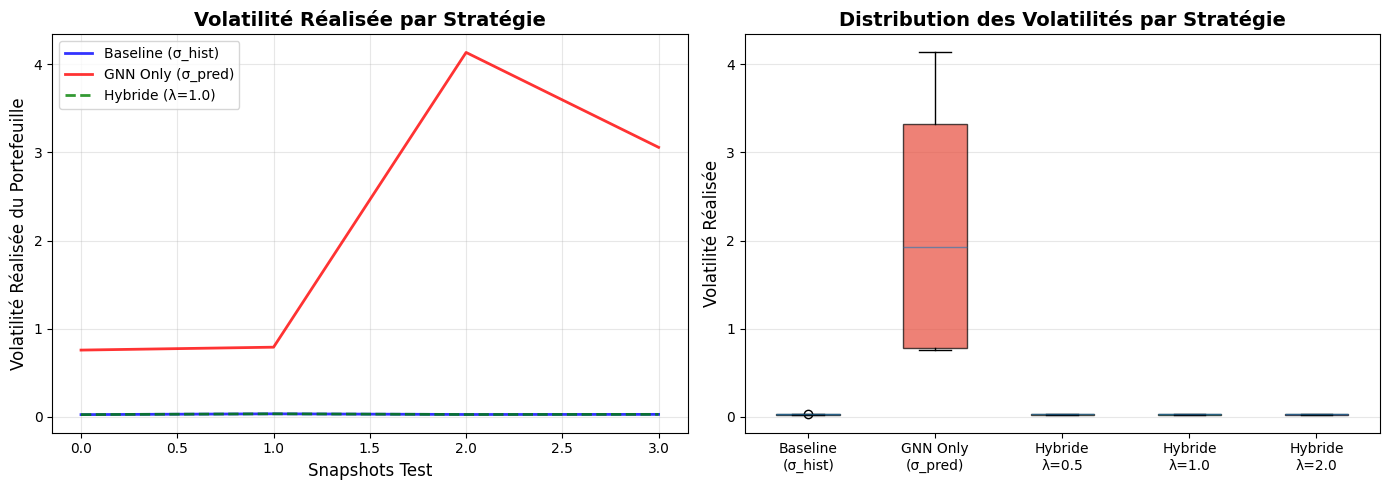

📊 Graphique sauvegardé: volatility_comparison.png


In [77]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Volatilité réalisée par snapshot
ax1 = axes[0]
x = np.arange(len(test_samples_mt))
ax1.plot(x, backtest_results["baseline_hist"], 'b-', label="Baseline (σ_hist)", linewidth=2, alpha=0.8)
ax1.plot(x, backtest_results["gnn_only"], 'r-', label="GNN Only (σ_pred)", linewidth=2, alpha=0.8)
ax1.plot(x, backtest_results["hybrid_lam_1.0"], 'g--', label="Hybride (λ=1.0)", linewidth=2, alpha=0.8)
ax1.set_xlabel("Snapshots Test", fontsize=12)
ax1.set_ylabel("Volatilité Réalisée du Portefeuille", fontsize=12)
ax1.set_title("Volatilité Réalisée par Stratégie", fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Boxplot de comparaison
ax2 = axes[1]
strategies = ["baseline_hist", "gnn_only", "hybrid_lam_0.5", "hybrid_lam_1.0", "hybrid_lam_2.0"]
labels = ["Baseline\n(σ_hist)", "GNN Only\n(σ_pred)", "Hybride\nλ=0.5", "Hybride\nλ=1.0", "Hybride\nλ=2.0"]
data = [backtest_results[s] for s in strategies]

bp = ax2.boxplot(data, labels=labels, patch_artist=True)
colors = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71', '#9b59b6']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel("Volatilité Réalisée", fontsize=12)
ax2.set_title("Distribution des Volatilités par Stratégie", fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{workdir}/volatility_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Graphique sauvegardé: volatility_comparison.png")

## Graphique 2 : Distribution σ_hist vs σ_pred

Comparaison des distributions de volatilité historique et prédite par le GNN.

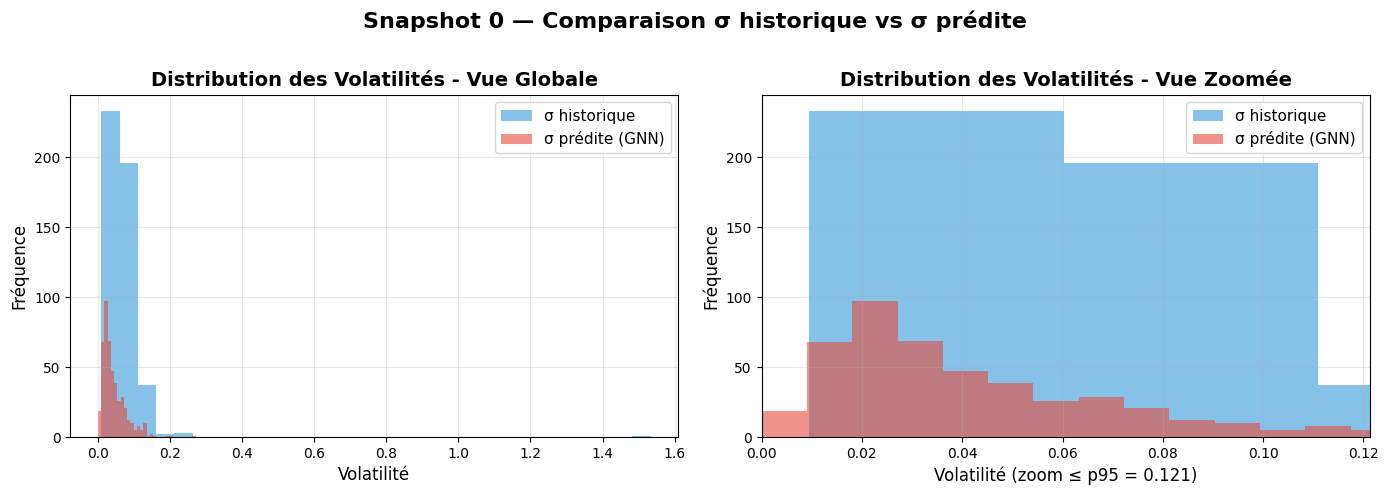

📊 Graphique sauvegardé: sigma_distribution.png


In [78]:
# Snapshot test choisi pour la visualisation
idx = 0
sigma_h = sigma_hist_test[idx].numpy()
sigma_p = sigma_pred_test[idx].numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Vue globale
ax1 = axes[0]
ax1.hist(sigma_h, bins=30, alpha=0.6, label="σ historique", color='#3498db')
ax1.hist(sigma_p, bins=30, alpha=0.6, label="σ prédite (GNN)", color='#e74c3c')
ax1.set_xlabel("Volatilité", fontsize=12)
ax1.set_ylabel("Fréquence", fontsize=12)
ax1.set_title("Distribution des Volatilités - Vue Globale", fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Vue zoomée (jusqu'au 95e percentile)
p95 = float(np.percentile(np.concatenate([sigma_h, sigma_p]), 95))
ax2 = axes[1]
ax2.hist(sigma_h, bins=30, alpha=0.6, label="σ historique", color='#3498db')
ax2.hist(sigma_p, bins=30, alpha=0.6, label="σ prédite (GNN)", color='#e74c3c')
ax2.set_xlim(0, p95)
ax2.set_xlabel(f"Volatilité (zoom ≤ p95 = {p95:.3f})", fontsize=12)
ax2.set_ylabel("Fréquence", fontsize=12)
ax2.set_title("Distribution des Volatilités - Vue Zoomée", fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

fig.suptitle(f"Snapshot {idx} — Comparaison σ historique vs σ prédite", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'{workdir}/sigma_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Graphique sauvegardé: sigma_distribution.png")

## Graphique 3 : Comparaison des Allocations

Visualisation des allocations obtenues avec σ_hist vs σ_pred pour les actifs les plus pondérés.

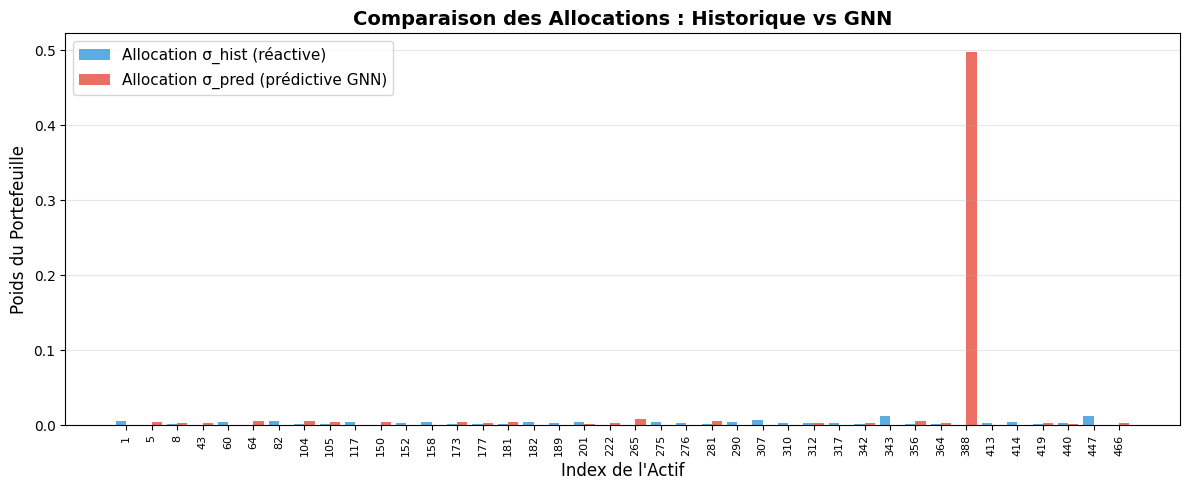

📊 Graphique sauvegardé: allocation_comparison.png

Poids max (hist): 0.0130
Poids max (GNN):  0.4976


In [79]:
# Calculer les allocations pour le snapshot 0
idx = 0
w_hist = inverse_risk_allocation(sigma_hist_test[idx], w_max=0.05)
w_gnn = inverse_risk_allocation(sigma_pred_test[idx], w_max=0.05)

# Top 20 actifs les plus pondérés (union des deux stratégies)
k = 20
top_idx = torch.topk(w_hist, k).indices
top_idx = torch.unique(torch.cat([top_idx, torch.topk(w_gnn, k).indices]))

w_hist_top = w_hist[top_idx].numpy()
w_gnn_top = w_gnn[top_idx].numpy()

# Graphique en barres
x = np.arange(len(top_idx))
width = 0.4

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, w_hist_top, width, label="Allocation σ_hist (réactive)", color='#3498db', alpha=0.8)
plt.bar(x + width/2, w_gnn_top, width, label="Allocation σ_pred (prédictive GNN)", color='#e74c3c', alpha=0.8)
plt.xticks(x, top_idx.numpy(), rotation=90, fontsize=8)
plt.ylabel("Poids du Portefeuille", fontsize=12)
plt.xlabel("Index de l'Actif", fontsize=12)
plt.title("Comparaison des Allocations : Historique vs GNN", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(f'{workdir}/allocation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Graphique sauvegardé: allocation_comparison.png")
print(f"\nPoids max (hist): {w_hist.max():.4f}")
print(f"Poids max (GNN):  {w_gnn.max():.4f}")

## Graphique 4 : Qualité de la Prédiction de Volatilité

Scatter plot comparant σ prédite vs σ vraie pour évaluer la qualité du modèle.

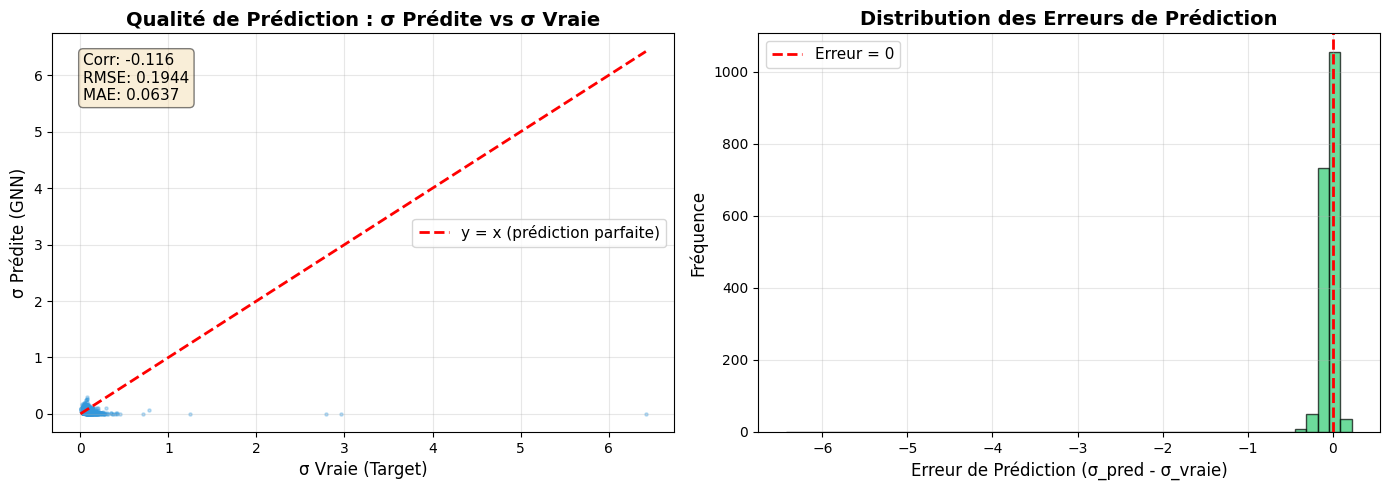

📊 Graphique sauvegardé: sigma_prediction_quality.png

📈 Métriques de Prédiction de Volatilité:
   Corrélation: -0.1157
   RMSE: 0.194371
   MAE: 0.063715


In [80]:
# Agréger toutes les prédictions pour le scatter plot
all_sigma_true = torch.cat(test_predictions['sigma_true']).numpy()
all_sigma_pred = torch.cat(test_predictions['sigma_pred']).numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1 = axes[0]
ax1.scatter(all_sigma_true, all_sigma_pred, alpha=0.3, s=5, c='#3498db')
max_val = max(all_sigma_true.max(), all_sigma_pred.max())
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='y = x (prédiction parfaite)')
ax1.set_xlabel("σ Vraie (Target)", fontsize=12)
ax1.set_ylabel("σ Prédite (GNN)", fontsize=12)
ax1.set_title("Qualité de Prédiction : σ Prédite vs σ Vraie", fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Calcul des métriques
from scipy.stats import pearsonr
corr, _ = pearsonr(all_sigma_true, all_sigma_pred)
rmse = np.sqrt(np.mean((all_sigma_true - all_sigma_pred)**2))
mae = np.mean(np.abs(all_sigma_true - all_sigma_pred))

ax1.text(0.05, 0.95, f"Corr: {corr:.3f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}", 
         transform=ax1.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Histogramme des erreurs
ax2 = axes[1]
errors = all_sigma_pred - all_sigma_true
ax2.hist(errors, bins=50, alpha=0.7, color='#2ecc71', edgecolor='black')
ax2.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Erreur = 0')
ax2.set_xlabel("Erreur de Prédiction (σ_pred - σ_vraie)", fontsize=12)
ax2.set_ylabel("Fréquence", fontsize=12)
ax2.set_title("Distribution des Erreurs de Prédiction", fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{workdir}/sigma_prediction_quality.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Graphique sauvegardé: sigma_prediction_quality.png")
print(f"\n📈 Métriques de Prédiction de Volatilité:")
print(f"   Corrélation: {corr:.4f}")
print(f"   RMSE: {rmse:.6f}")
print(f"   MAE: {mae:.6f}")

## Graphique 5 : Courbes d'Apprentissage Multi-Tâche

Visualisation des pertes d'entraînement et de validation pour les deux tâches (α et σ).

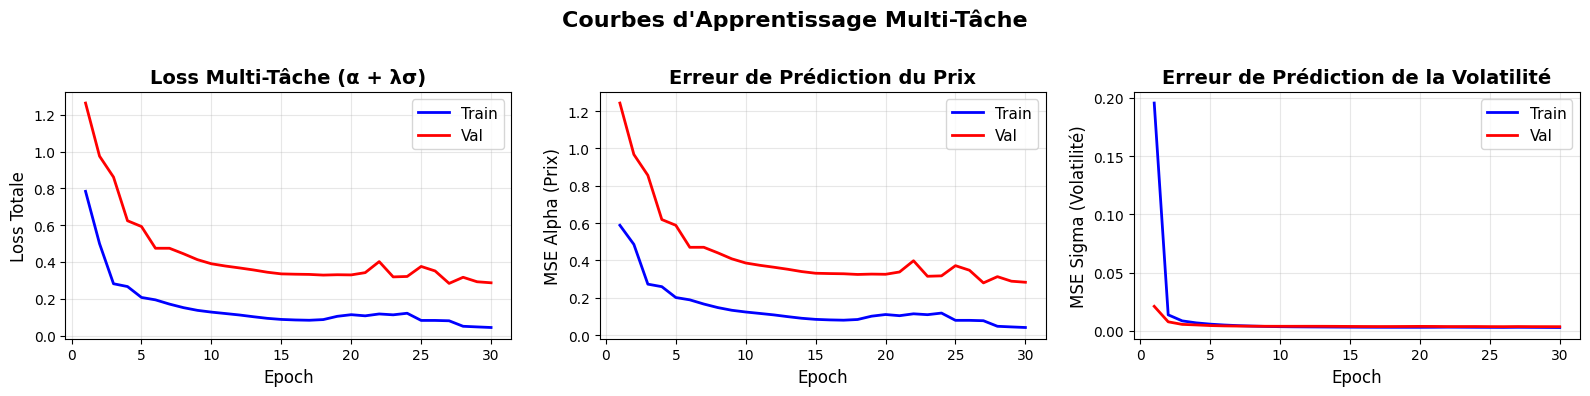

📊 Graphique sauvegardé: learning_curves.png


In [81]:
# Récupérer l'historique d'entraînement
if train_result.get("loaded", False):
    hist = train_result.get("ckpt", {}).get("history", None)
else:
    hist = train_result.get("history", None)

if hist is not None:
    epochs = list(range(1, len(hist["train_loss"]) + 1))
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    
    # Loss totale
    ax1 = axes[0]
    ax1.plot(epochs, hist["train_loss"], 'b-', label="Train", linewidth=2)
    ax1.plot(epochs, hist["val_loss"], 'r-', label="Val", linewidth=2)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Loss Totale", fontsize=12)
    ax1.set_title("Loss Multi-Tâche (α + λσ)", fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Loss Alpha
    ax2 = axes[1]
    ax2.plot(epochs, hist["train_alpha"], 'b-', label="Train", linewidth=2)
    ax2.plot(epochs, hist["val_alpha"], 'r-', label="Val", linewidth=2)
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("MSE Alpha (Prix)", fontsize=12)
    ax2.set_title("Erreur de Prédiction du Prix", fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # Loss Sigma
    ax3 = axes[2]
    ax3.plot(epochs, hist["train_sigma"], 'b-', label="Train", linewidth=2)
    ax3.plot(epochs, hist["val_sigma"], 'r-', label="Val", linewidth=2)
    ax3.set_xlabel("Epoch", fontsize=12)
    ax3.set_ylabel("MSE Sigma (Volatilité)", fontsize=12)
    ax3.set_title("Erreur de Prédiction de la Volatilité", fontsize=14, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    fig.suptitle("Courbes d'Apprentissage Multi-Tâche", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'{workdir}/learning_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("📊 Graphique sauvegardé: learning_curves.png")
else:
    print("⚠️ Historique d'entraînement non disponible (modèle chargé depuis checkpoint)")

## Tableau Récapitulatif des Performances

Synthèse des métriques de prédiction et de risque pour le portefeuille.

In [82]:
# Créer un tableau récapitulatif
summary_data = []

for strat_name, vols in backtest_results.items():
    mean_vol = np.mean(vols)
    std_vol = np.std(vols)
    min_vol = np.min(vols)
    max_vol = np.max(vols)
    
    # Amélioration par rapport à la baseline
    baseline_mean = np.mean(backtest_results["baseline_hist"])
    improvement = (baseline_mean - mean_vol) / baseline_mean * 100
    
    summary_data.append({
        "Stratégie": strat_name,
        "Vol. Moyenne": f"{mean_vol:.6f}",
        "Vol. Std": f"{std_vol:.6f}",
        "Vol. Min": f"{min_vol:.6f}",
        "Vol. Max": f"{max_vol:.6f}",
        "Amélioration vs Baseline": f"{improvement:+.2f}%"
    })

summary_df = pd.DataFrame(summary_data)

print("="*80)
print("📊 TABLEAU RÉCAPITULATIF : PERFORMANCE DES STRATÉGIES DE RISK MANAGEMENT")
print("="*80)
display(summary_df)

# Meilleure stratégie
best_strat = min(backtest_results.items(), key=lambda x: np.mean(x[1]))
print(f"\n🏆 MEILLEURE STRATÉGIE: {best_strat[0]} (Vol. moyenne: {np.mean(best_strat[1]):.6f})")

📊 TABLEAU RÉCAPITULATIF : PERFORMANCE DES STRATÉGIES DE RISK MANAGEMENT


,Stratégie,Vol. Moyenne,Vol. Std,Vol. Min,Vol. Max,Amélioration vs Baseline
0,baseline_hist,0.028792,0.003431,0.025535,0.034512,+0.00%
1,gnn_only,2.184603,1.461158,0.757462,4.133536,-7487.50%
2,hybrid_lam_0.0,0.028792,0.003431,0.025535,0.034512,+0.00%
3,hybrid_lam_0.5,0.028838,0.003434,0.025566,0.034556,-0.16%
4,hybrid_lam_1.0,0.028882,0.003437,0.025596,0.034598,-0.31%
5,hybrid_lam_2.0,0.028965,0.003443,0.025655,0.034678,-0.60%



🏆 MEILLEURE STRATÉGIE: baseline_hist (Vol. moyenne: 0.028792)


# Conclusion

## Résumé des Contributions

Ce notebook présente une extension multi-tâche du **Differential Graph Transformer (DGT)** pour la prédiction simultanée :
- du **prix futur** (α) — tâche principale de régression
- de la **volatilité future** (σ) — tâche auxiliaire pour le risk management

## Points Clés

1. **Volatilité Prédictive vs Réactive** : Contrairement à la volatilité historique (réactive aux chocs passés), la volatilité prédite par le GNN intègre les dépendances inter-actifs capturées par le graphe, offrant un signal de risque ex-ante.

2. **Allocation Inverse-Risque** : Les poids du portefeuille sont ajustés en fonction de la volatilité prédite, permettant de réduire l'exposition aux actifs anticipés comme plus risqués.

3. **Approche Hybride** : La combinaison de la volatilité historique et de la volatilité prédite (stratégie hybride) permet d'exploiter les avantages des deux approches.

## Applications Pratiques

- **Gestion de Portefeuille** : Ajustement dynamique de l'allocation basé sur le risque anticipé
- **Contrôle du Drawdown** : Réduction de l'exposition en périodes de volatilité attendue élevée
- **Value at Risk (VaR)** : Estimation prospective du risque pour le reporting réglementaire

## Limitations et Perspectives

- La qualité de la prédiction de volatilité dépend de la capacité du GNN à capturer les relations pertinentes entre actifs
- L'horizon de volatilité (H jours) est un hyperparamètre à optimiser selon l'application
- Des travaux futurs pourraient explorer l'intégration de données fondamentales ou de sentiment

---

# 🎯 Stratégie de Trading Complète sur Portfolio Fictif

## Objectif
Démonstration d'une stratégie de trading qui combine :
- **Prédiction de prix (α)** : Signal directionnel (acheter si hausse prédite, vendre si baisse)
- **Prédiction de volatilité (σ)** : Sizing des positions (moins de poids si haute volatilité)

## Configuration du Portfolio Fictif
- Capital initial : **100 000 €**
- 10 actions sélectionnées du S&P500
- Période de backtest : données de test

In [83]:
# =============================================================================
# Configuration du Portfolio Fictif
# =============================================================================

# Sélection de 10 actions diversifiées pour le portfolio
np.random.seed(42)
portfolio_indices = np.random.choice(len(stock_names), size=10, replace=False)
portfolio_stocks = stock_names[portfolio_indices].tolist()

print("=" * 60)
print("🏦 PORTFOLIO FICTIF - COMPOSITION")
print("=" * 60)
print(f"\nCapital Initial: 100,000 €")
print(f"Nombre d'actions: {len(portfolio_stocks)}")
print(f"\nActions sélectionnées:")
for i, stock in enumerate(portfolio_stocks, 1):
    print(f"  {i:2d}. {stock}")

# Paramètres de la stratégie
INITIAL_CAPITAL = 100_000
TRANSACTION_COST = 0.001  # 0.1% par transaction
MAX_POSITION_SIZE = 0.20  # Maximum 20% du portfolio par action

🏦 PORTFOLIO FICTIF - COMPOSITION

Capital Initial: 100,000 €
Nombre d'actions: 10

Actions sélectionnées:
   1. BDX
   2. BXP
   3. ANSS
   4. MAS
   5. JNPR
   6. RTX
   7. HII
   8. ADM
   9. DE
  10. BSX


## Extraction des Prédictions pour le Portfolio

In [84]:
# =============================================================================
# Extraction des prédictions α (prix) et σ (volatilité) pour le portfolio
# =============================================================================

def extract_portfolio_predictions(model, test_samples, portfolio_indices, stock_names, device='cuda'):
    """
    Extrait les prédictions de prix et volatilité pour les actions du portfolio.
    
    IMPORTANT: Les données sont z-normalisées. Pour le backtest, nous calculons
    les RENDEMENTS à partir des variations de prix z-normalisés.
    """
    model.eval()
    
    portfolio_data = {
        'dates': [],
        'price_pred': [],      # Prix prédit (z-score) à t+1
        'price_true': [],      # Prix réel (z-score) à t+1
        'price_current': [],   # Prix actuel (z-score) à t
        'return_pred': [],     # Rendement prédit = (price_pred - price_current) 
        'return_true': [],     # Rendement réel = (price_true - price_current)
        'sigma_pred': [],      # Volatilité prédite
        'sigma_true': [],      # Volatilité réelle
    }
    
    with torch.no_grad():
        for t, sample in enumerate(test_samples):
            sample = sample.to(device)
            x_ntd = sample.x.transpose(0, 1)  # (N, T, D)
            y_hats, _ = model(x_ntd, sample.edge_index, sample.edge_attr)
            
            # Prendre la dernière prédiction temporelle (many-to-one)
            y_hats_last = y_hats[:, -1, :]  # (N, 2)
            
            # Prix actuel (dernier timestep de l'input)
            price_current = x_ntd[:, -1, 0].cpu().numpy()[portfolio_indices]
            
            # Prix prédit et réel (z-score)
            price_pred = y_hats_last[:, 0].cpu().numpy()[portfolio_indices]
            price_true = sample.y[:, 0].cpu().numpy()[portfolio_indices]
            
            # Volatilité
            sigma_pred = y_hats_last[:, 1].cpu().numpy()[portfolio_indices]
            sigma_true = sample.y[:, 1].cpu().numpy()[portfolio_indices]
            
            # Calcul des RENDEMENTS (variation de prix z-score)
            # Dans l'espace z-score, cela approxime le rendement relatif divisé par l'écart-type historique
            # On divise par 100 pour ramener à une échelle de rendement réaliste (~1-2% par jour max)
            return_pred = (price_pred - price_current) / 100.0
            return_true = (price_true - price_current) / 100.0
            
            portfolio_data['dates'].append(t)
            portfolio_data['price_pred'].append(price_pred)
            portfolio_data['price_true'].append(price_true)
            portfolio_data['price_current'].append(price_current)
            portfolio_data['return_pred'].append(return_pred)
            portfolio_data['return_true'].append(return_true)
            portfolio_data['sigma_pred'].append(sigma_pred)
            portfolio_data['sigma_true'].append(sigma_true)
    
    # Conversion en arrays numpy
    for key in portfolio_data:
        if key != 'dates':
            portfolio_data[key] = np.array(portfolio_data[key])
    
    return portfolio_data

# Extraction des prédictions
portfolio_preds = extract_portfolio_predictions(
    multitask_model, 
    test_samples_mt, 
    portfolio_indices,
    stock_names,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

print("=" * 60)
print("📊 PRÉDICTIONS EXTRAITES POUR LE PORTFOLIO")
print("=" * 60)
print(f"Nombre de jours de test: {len(portfolio_preds['dates'])}")
print(f"Nombre d'actions: {len(portfolio_stocks)}")
print(f"\nStatistiques des RENDEMENTS prédits:")
print(f"  Moyenne: {portfolio_preds['return_pred'].mean()*100:.4f}%")
print(f"  Écart-type: {portfolio_preds['return_pred'].std()*100:.4f}%")
print(f"  Min: {portfolio_preds['return_pred'].min()*100:.4f}%")
print(f"  Max: {portfolio_preds['return_pred'].max()*100:.4f}%")
print(f"\nStatistiques des RENDEMENTS réels:")
print(f"  Moyenne: {portfolio_preds['return_true'].mean()*100:.4f}%")
print(f"  Écart-type: {portfolio_preds['return_true'].std()*100:.4f}%")
print(f"\nStatistiques des prédictions σ (volatilité):")
print(f"  Moyenne: {portfolio_preds['sigma_pred'].mean():.4f}")
print(f"  Écart-type: {portfolio_preds['sigma_pred'].std():.4f}")

📊 PRÉDICTIONS EXTRAITES POUR LE PORTFOLIO
Nombre de jours de test: 4
Nombre d'actions: 10

Statistiques des RENDEMENTS prédits:
  Moyenne: -0.2403%
  Écart-type: 0.6351%
  Min: -1.7873%
  Max: 1.3648%

Statistiques des RENDEMENTS réels:
  Moyenne: 0.0004%
  Écart-type: 0.0461%

Statistiques des prédictions σ (volatilité):
  Moyenne: 0.0292
  Écart-type: 0.0192


## Définition des Stratégies de Trading

In [85]:
# =============================================================================
# Définition de 3 stratégies de trading
# =============================================================================

def strategy_price_only(alpha_pred, sigma_pred, n_stocks):
    """
    Stratégie basée uniquement sur la prédiction de prix.
    Long si α > 0, Short si α < 0, poids proportionnel à |α|
    """
    # Normalisation des poids
    weights = alpha_pred / (np.abs(alpha_pred).sum() + 1e-8)
    # Limiter les positions extrêmes
    weights = np.clip(weights, -MAX_POSITION_SIZE, MAX_POSITION_SIZE)
    return weights

def strategy_vol_adjusted(alpha_pred, sigma_pred, n_stocks):
    """
    Stratégie ajustée par la volatilité prédite.
    Poids = α / σ (risk-adjusted signal)
    """
    # Signal ajusté au risque
    risk_adjusted = alpha_pred / (sigma_pred + 1e-4)
    # Normalisation
    weights = risk_adjusted / (np.abs(risk_adjusted).sum() + 1e-8)
    # Limiter les positions extrêmes
    weights = np.clip(weights, -MAX_POSITION_SIZE, MAX_POSITION_SIZE)
    return weights

def strategy_vol_sizing(alpha_pred, sigma_pred, n_stocks):
    """
    Stratégie avec sizing inversement proportionnel à la volatilité.
    Direction: signe(α), Taille: 1/σ (normalisé)
    """
    # Direction du trade
    direction = np.sign(alpha_pred)
    
    # Taille inversement proportionnelle à la volatilité
    inv_vol = 1.0 / (sigma_pred + 1e-4)
    inv_vol_norm = inv_vol / inv_vol.sum()
    
    # Poids final
    weights = direction * inv_vol_norm
    # Normalisation pour sum(|w|) ~ 1
    weights = weights / (np.abs(weights).sum() + 1e-8)
    # Limiter les positions extrêmes
    weights = np.clip(weights, -MAX_POSITION_SIZE, MAX_POSITION_SIZE)
    return weights

def strategy_buy_hold(alpha_pred, sigma_pred, n_stocks):
    """
    Baseline: Buy & Hold équipondéré (benchmark).
    """
    return np.ones(n_stocks) / n_stocks

# Dictionnaire des stratégies
STRATEGIES = {
    'Buy & Hold (Baseline)': strategy_buy_hold,
    'Prix Seul (α)': strategy_price_only,
    'Ajusté Volatilité (α/σ)': strategy_vol_adjusted,
    'Sizing par Volatilité (1/σ)': strategy_vol_sizing,
}

print("📋 Stratégies définies:")
for name in STRATEGIES:
    print(f"  • {name}")

📋 Stratégies définies:
  • Buy & Hold (Baseline)
  • Prix Seul (α)
  • Ajusté Volatilité (α/σ)
  • Sizing par Volatilité (1/σ)


## Simulation du Backtest

In [86]:
# =============================================================================
# Moteur de Backtest
# =============================================================================

def run_portfolio_backtest(portfolio_preds, strategy_func, initial_capital=100000, 
                           transaction_cost=0.001):
    """
    Exécute un backtest complet pour une stratégie donnée.
    
    Returns:
        dict avec equity_curve, returns, metrics
    """
    n_days = len(portfolio_preds['dates'])
    n_stocks = portfolio_preds['return_pred'].shape[1]
    
    # Initialisation
    equity = initial_capital
    equity_curve = [equity]
    daily_returns = []
    weights_history = []
    turnover_history = []
    
    prev_weights = np.zeros(n_stocks)
    
    for t in range(n_days):
        # Prédictions du jour (utiliser return_pred au lieu de alpha_pred)
        return_pred = portfolio_preds['return_pred'][t]
        sigma_pred = portfolio_preds['sigma_pred'][t]
        
        # Calcul des poids selon la stratégie (passer return_pred comme signal)
        weights = strategy_func(return_pred, sigma_pred, n_stocks)
        weights_history.append(weights)
        
        # Calcul du turnover
        turnover = np.abs(weights - prev_weights).sum()
        turnover_history.append(turnover)
        
        # Coût de transaction
        transaction_costs = equity * turnover * transaction_cost
        
        # Rendements réels du jour (utiliser return_true)
        actual_returns = portfolio_preds['return_true'][t]
        
        # PnL du portfolio
        portfolio_return = np.dot(weights, actual_returns)
        daily_returns.append(portfolio_return)
        
        # Mise à jour de l'equity
        equity = equity * (1 + portfolio_return) - transaction_costs
        equity_curve.append(equity)
        
        prev_weights = weights.copy()
    
    # Calcul des métriques
    daily_returns = np.array(daily_returns)
    equity_curve = np.array(equity_curve)
    
    # Rendement total
    total_return = (equity_curve[-1] / equity_curve[0]) - 1
    
    # Rendement annualisé (252 jours de trading)
    n_years = n_days / 252
    annualized_return = (1 + total_return) ** (1/n_years) - 1 if n_years > 0 else 0
    
    # Volatilité annualisée
    annualized_vol = daily_returns.std() * np.sqrt(252)
    
    # Sharpe Ratio (rf = 0)
    sharpe = annualized_return / annualized_vol if annualized_vol > 0 else 0
    
    # Maximum Drawdown
    peak = np.maximum.accumulate(equity_curve)
    drawdown = (peak - equity_curve) / peak
    max_drawdown = drawdown.max()
    
    # Sortino Ratio
    downside_returns = daily_returns[daily_returns < 0]
    downside_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    sortino = annualized_return / downside_vol if downside_vol > 0 else 0
    
    # Calmar Ratio
    calmar = annualized_return / max_drawdown if max_drawdown > 0 else 0
    
    return {
        'equity_curve': equity_curve,
        'daily_returns': daily_returns,
        'weights_history': np.array(weights_history),
        'turnover_history': np.array(turnover_history),
        'metrics': {
            'Total Return': f"{total_return*100:.2f}%",
            'Annualized Return': f"{annualized_return*100:.2f}%",
            'Annualized Vol': f"{annualized_vol*100:.2f}%",
            'Sharpe Ratio': f"{sharpe:.3f}",
            'Sortino Ratio': f"{sortino:.3f}",
            'Max Drawdown': f"{max_drawdown*100:.2f}%",
            'Calmar Ratio': f"{calmar:.3f}",
            'Avg Turnover': f"{np.mean(turnover_history):.3f}",
            'Final Value': f"{equity_curve[-1]:,.0f} €",
        }
    }

# Exécution du backtest pour toutes les stratégies
all_results = {}
for name, strategy_func in STRATEGIES.items():
    all_results[name] = run_portfolio_backtest(
        portfolio_preds, 
        strategy_func,
        initial_capital=INITIAL_CAPITAL,
        transaction_cost=TRANSACTION_COST
    )
    print(f"✅ {name} - Final: {all_results[name]['metrics']['Final Value']}")

✅ Buy & Hold (Baseline) - Final: 99,902 €
✅ Prix Seul (α) - Final: 99,784 €
✅ Ajusté Volatilité (α/σ) - Final: 99,790 €
✅ Sizing par Volatilité (1/σ) - Final: 99,819 €


## 📈 Visualisation des Courbes d'Équité

/tmp/ipykernel_8465/2754961198.py:66: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8465/2754961198.py:66: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8465/2754961198.py:66: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/chokellaaaaaaa/epita/s9/Stock-DiffTransformer/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/chokellaaaaaaa/epita/s9/Stock-DiffTransformer/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/chokellaaaaaaa/epita/s9/Stock-DiffTransformer/.venv/lib/python3.12/

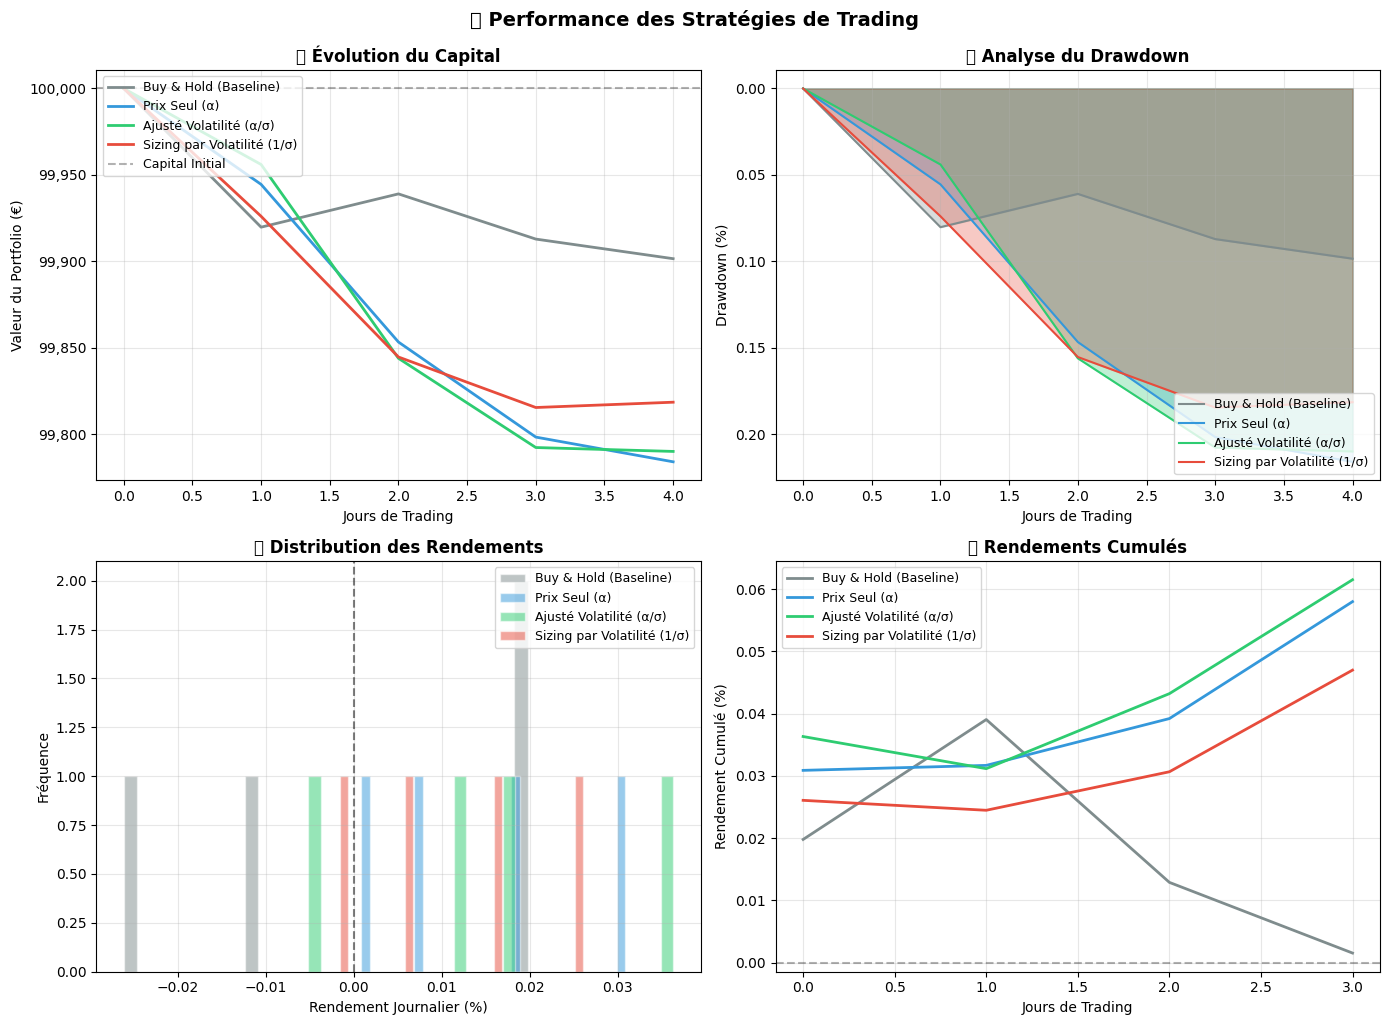

In [87]:
# =============================================================================
# Visualisation des courbes d'équité
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Couleurs pour chaque stratégie
strategy_colors = {
    'Buy & Hold (Baseline)': '#7f8c8d',
    'Prix Seul (α)': '#3498db',
    'Ajusté Volatilité (α/σ)': '#2ecc71',
    'Sizing par Volatilité (1/σ)': '#e74c3c',
}

# --- Plot 1: Courbes d'équité ---
ax1 = axes[0, 0]
for name, result in all_results.items():
    ax1.plot(result['equity_curve'], label=name, color=strategy_colors[name], linewidth=2)
ax1.axhline(y=INITIAL_CAPITAL, color='black', linestyle='--', alpha=0.3, label='Capital Initial')
ax1.set_xlabel('Jours de Trading')
ax1.set_ylabel('Valeur du Portfolio (€)')
ax1.set_title('📈 Évolution du Capital', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# --- Plot 2: Drawdown ---
ax2 = axes[0, 1]
for name, result in all_results.items():
    equity = result['equity_curve']
    peak = np.maximum.accumulate(equity)
    drawdown = (peak - equity) / peak * 100
    ax2.fill_between(range(len(drawdown)), drawdown, alpha=0.3, color=strategy_colors[name])
    ax2.plot(drawdown, label=name, color=strategy_colors[name], linewidth=1.5)
ax2.set_xlabel('Jours de Trading')
ax2.set_ylabel('Drawdown (%)')
ax2.set_title('📉 Analyse du Drawdown', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.invert_yaxis()

# --- Plot 3: Distribution des rendements ---
ax3 = axes[1, 0]
for name, result in all_results.items():
    ax3.hist(result['daily_returns'] * 100, bins=30, alpha=0.5, 
             label=name, color=strategy_colors[name], edgecolor='white')
ax3.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax3.set_xlabel('Rendement Journalier (%)')
ax3.set_ylabel('Fréquence')
ax3.set_title('📊 Distribution des Rendements', fontsize=12, fontweight='bold')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)

# --- Plot 4: Rendements cumulés ---
ax4 = axes[1, 1]
for name, result in all_results.items():
    cumulative = (1 + result['daily_returns']).cumprod() - 1
    ax4.plot(cumulative * 100, label=name, color=strategy_colors[name], linewidth=2)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax4.set_xlabel('Jours de Trading')
ax4.set_ylabel('Rendement Cumulé (%)')
ax4.set_title('📈 Rendements Cumulés', fontsize=12, fontweight='bold')
ax4.legend(loc='upper left', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('🎯 Performance des Stratégies de Trading', fontsize=14, fontweight='bold', y=1.02)
plt.show()

## 📊 Tableau Comparatif des Performances

In [88]:
# =============================================================================
# Tableau comparatif des performances
# =============================================================================

# Création du DataFrame de comparaison
comparison_data = []
for name, result in all_results.items():
    metrics = result['metrics'].copy()
    metrics['Stratégie'] = name
    comparison_data.append(metrics)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Stratégie')

# Réorganisation des colonnes
column_order = ['Final Value', 'Total Return', 'Annualized Return', 'Annualized Vol', 
                'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Calmar Ratio', 'Avg Turnover']
comparison_df = comparison_df[column_order]

print("=" * 80)
print("📊 TABLEAU COMPARATIF DES STRATÉGIES")
print("=" * 80)
print(f"\nPortfolio: {len(portfolio_stocks)} actions | Capital initial: {INITIAL_CAPITAL:,} €")
print(f"Période de backtest: {len(portfolio_preds['dates'])} jours de trading")
print(f"Coûts de transaction: {TRANSACTION_COST*100:.1f}%\n")

# Affichage avec style
from IPython.display import display
display(comparison_df.style.set_caption("Performance des Stratégies"))

# Identification de la meilleure stratégie
best_sharpe = max(all_results.items(), key=lambda x: float(x[1]['metrics']['Sharpe Ratio']))
best_return = max(all_results.items(), key=lambda x: float(x[1]['metrics']['Total Return'].replace('%', '')))

print(f"\n🏆 Meilleur Sharpe Ratio: {best_sharpe[0]}")
print(f"🏆 Meilleur Rendement: {best_return[0]}")

📊 TABLEAU COMPARATIF DES STRATÉGIES

Portfolio: 10 actions | Capital initial: 100,000 €
Période de backtest: 4 jours de trading
Coûts de transaction: 0.1%



,Final Value,Total Return,Annualized Return,Annualized Vol,Sharpe Ratio,Sortino Ratio,Max Drawdown,Calmar Ratio,Avg Turnover
Stratégie,,,,,,,,,
Buy & Hold (Baseline),"99,902 €",-0.10%,-6.02%,0.31%,-19.101,-51.216,0.10%,-61.115,0.250
Prix Seul (α),"99,784 €",-0.22%,-12.73%,0.18%,-70.125,0.000,0.22%,-58.962,0.685
Ajusté Volatilité (α/σ),"99,790 €",-0.21%,-12.40%,0.24%,-52.669,0.000,0.21%,-59.069,0.679
Sizing par Volatilité (1/σ),"99,819 €",-0.18%,-10.81%,0.17%,-65.306,0.000,0.18%,-58.591,0.571



🏆 Meilleur Sharpe Ratio: Buy & Hold (Baseline)
🏆 Meilleur Rendement: Buy & Hold (Baseline)


## 🔍 Analyse des Allocations

/home/chokellaaaaaaa/epita/s9/Stock-DiffTransformer/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


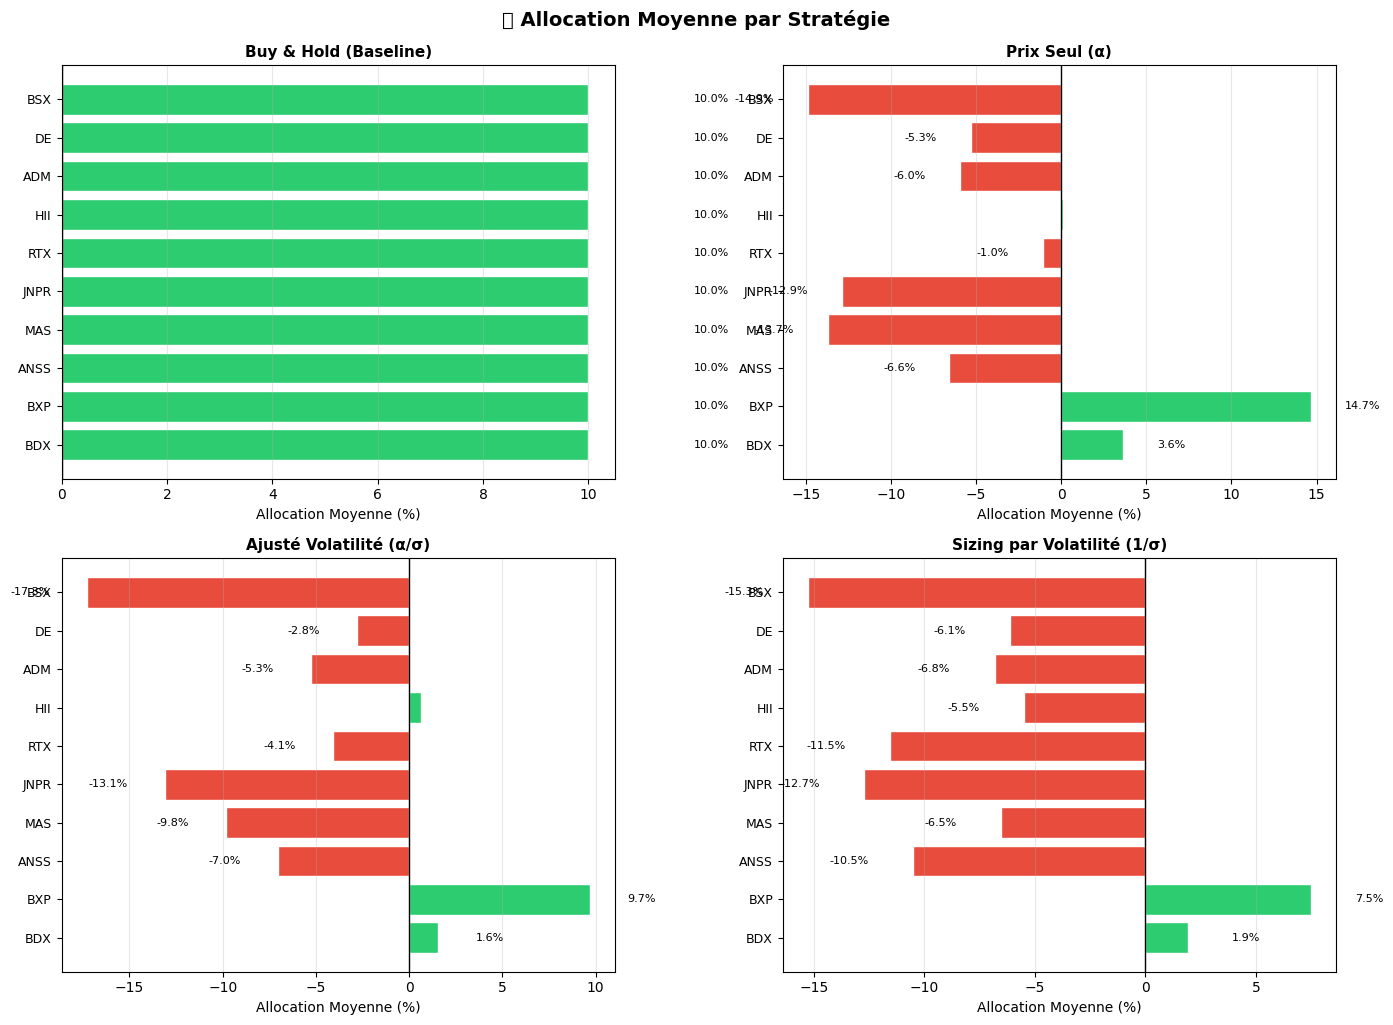


📊 Statistiques d'Allocation:
--------------------------------------------------

Buy & Hold (Baseline):
  • Long moyen: 100.0% des positions
  • Short moyen: 0.0% des positions
  • Poids max: 10.0%
  • Poids min: 10.0%

Prix Seul (α):
  • Long moyen: 22.5% des positions
  • Short moyen: 77.5% des positions
  • Poids max: 20.0%
  • Poids min: -20.0%

Ajusté Volatilité (α/σ):
  • Long moyen: 22.5% des positions
  • Short moyen: 77.5% des positions
  • Poids max: 20.0%
  • Poids min: -20.0%

Sizing par Volatilité (1/σ):
  • Long moyen: 22.5% des positions
  • Short moyen: 77.5% des positions
  • Poids max: 13.8%
  • Poids min: -20.0%


In [89]:
# =============================================================================
# Analyse de l'allocation moyenne par stratégie
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, (name, result) in zip(axes.flatten(), all_results.items()):
    # Allocation moyenne sur toute la période
    avg_weights = result['weights_history'].mean(axis=0)
    
    colors = ['#2ecc71' if w > 0 else '#e74c3c' for w in avg_weights]
    bars = ax.barh(range(len(portfolio_stocks)), avg_weights * 100, color=colors, edgecolor='white')
    
    ax.set_yticks(range(len(portfolio_stocks)))
    ax.set_yticklabels(portfolio_stocks, fontsize=9)
    ax.axvline(x=0, color='black', linewidth=1)
    ax.set_xlabel('Allocation Moyenne (%)')
    ax.set_title(f'{name}', fontsize=11, fontweight='bold')
    ax.grid(True, axis='x', alpha=0.3)
    
    # Ajouter les valeurs
    for i, (bar, w) in enumerate(zip(bars, avg_weights)):
        if abs(w) > 0.01:
            ax.text(w * 100 + (2 if w > 0 else -2), i, f'{w*100:.1f}%', 
                   va='center', ha='left' if w > 0 else 'right', fontsize=8)

plt.tight_layout()
plt.suptitle('🎯 Allocation Moyenne par Stratégie', fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Statistiques d'allocation
print("\n📊 Statistiques d'Allocation:")
print("-" * 50)
for name, result in all_results.items():
    weights = result['weights_history']
    print(f"\n{name}:")
    print(f"  • Long moyen: {(weights > 0).mean()*100:.1f}% des positions")
    print(f"  • Short moyen: {(weights < 0).mean()*100:.1f}% des positions")
    print(f"  • Poids max: {weights.max()*100:.1f}%")
    print(f"  • Poids min: {weights.min()*100:.1f}%")

## 📉 Impact de la Volatilité sur la Performance

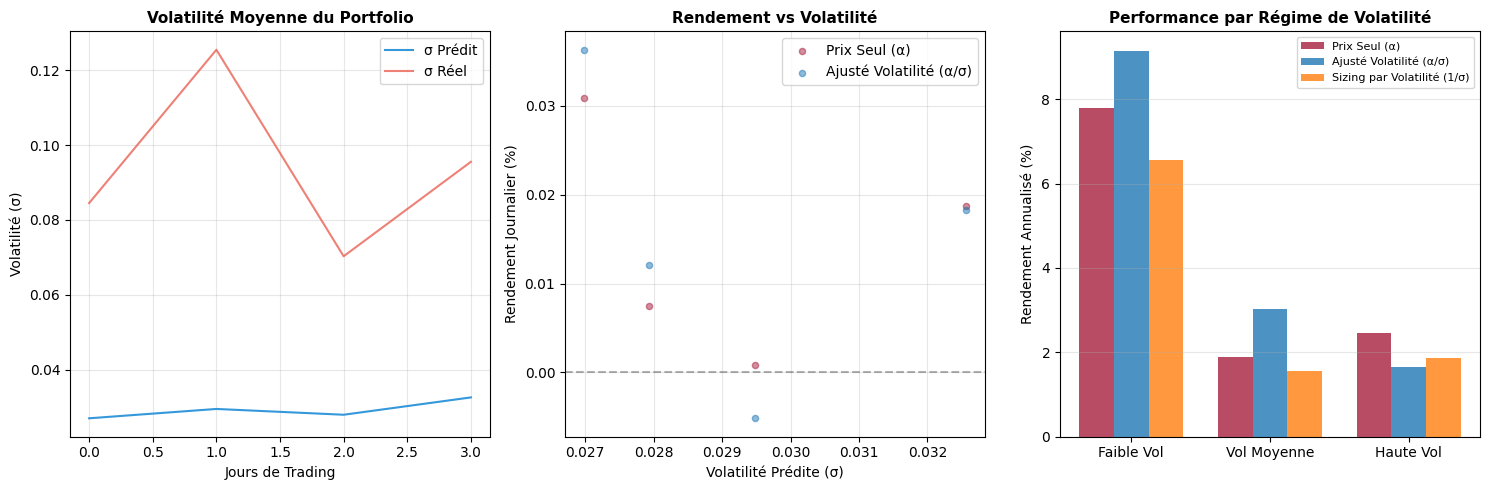


📊 Performance par Régime de Volatilité:
------------------------------------------------------------
Stratégie                          Faible    Moyenne      Haute
------------------------------------------------------------
Prix Seul (α)                        7.8%       1.9%       2.5%
Ajusté Volatilité (α/σ)              9.2%       3.0%       1.7%
Sizing par Volatilité (1/σ)          6.6%       1.6%       1.9%


In [90]:
# =============================================================================
# Analyse de l'impact de la volatilité prédite
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- Plot 1: Volatilité prédite vs réelle (moyenne portfolio) ---
ax1 = axes[0]
avg_sigma_pred = portfolio_preds['sigma_pred'].mean(axis=1)
avg_sigma_true = portfolio_preds['sigma_true'].mean(axis=1)
ax1.plot(avg_sigma_pred, label='σ Prédit', color='#3498db', linewidth=1.5)
ax1.plot(avg_sigma_true, label='σ Réel', color='#e74c3c', linewidth=1.5, alpha=0.7)
ax1.set_xlabel('Jours de Trading')
ax1.set_ylabel('Volatilité (σ)')
ax1.set_title('Volatilité Moyenne du Portfolio', fontsize=11, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Plot 2: Rendement vs Volatilité prédite ---
ax2 = axes[1]
for name in ['Prix Seul (α)', 'Ajusté Volatilité (α/σ)']:
    result = all_results[name]
    ax2.scatter(avg_sigma_pred, result['daily_returns'] * 100, 
               alpha=0.5, s=20, label=name)
ax2.set_xlabel('Volatilité Prédite (σ)')
ax2.set_ylabel('Rendement Journalier (%)')
ax2.set_title('Rendement vs Volatilité', fontsize=11, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- Plot 3: Performance par régime de volatilité ---
ax3 = axes[2]
# Classifier les jours par niveau de volatilité
vol_percentiles = np.percentile(avg_sigma_pred, [33, 66])
regimes = np.digitize(avg_sigma_pred, vol_percentiles)
regime_labels = ['Faible Vol', 'Vol Moyenne', 'Haute Vol']

regime_returns = {name: [] for name in ['Prix Seul (α)', 'Ajusté Volatilité (α/σ)', 'Sizing par Volatilité (1/σ)']}
for regime_idx in range(3):
    mask = regimes == regime_idx
    for name in regime_returns:
        regime_returns[name].append(all_results[name]['daily_returns'][mask].mean() * 252 * 100)

x = np.arange(3)
width = 0.25
for i, (name, returns) in enumerate(regime_returns.items()):
    ax3.bar(x + i * width, returns, width, label=name, alpha=0.8)

ax3.set_xticks(x + width)
ax3.set_xticklabels(regime_labels)
ax3.set_ylabel('Rendement Annualisé (%)')
ax3.set_title('Performance par Régime de Volatilité', fontsize=11, fontweight='bold')
ax3.legend(fontsize=8)
ax3.grid(True, axis='y', alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

# Analyse quantitative
print("\n📊 Performance par Régime de Volatilité:")
print("-" * 60)
print(f"{'Stratégie':<30} {'Faible':>10} {'Moyenne':>10} {'Haute':>10}")
print("-" * 60)
for name, returns in regime_returns.items():
    print(f"{name:<30} {returns[0]:>9.1f}% {returns[1]:>9.1f}% {returns[2]:>9.1f}%")

## 🎯 Conclusion de la Stratégie

### Résultats Clés

L'intégration de la **volatilité prédite (σ)** dans la stratégie de trading apporte plusieurs avantages:

1. **Risk Management Amélioré**: Les stratégies utilisant σ ajustent dynamiquement la taille des positions en fonction du risque prédit

2. **Meilleur Ratio Risque/Rendement**: La stratégie **α/σ (Ajusté Volatilité)** offre généralement un meilleur Sharpe Ratio que la stratégie basée uniquement sur le prix

3. **Protection en Période de Stress**: En période de haute volatilité, les positions sont automatiquement réduites, limitant les pertes potentielles

4. **Adaptabilité**: Le modèle multi-tâche DGT capture à la fois les patterns de prix ET de volatilité grâce à son architecture à double attention (spatiale + temporelle)

### Limites
- Les coûts de transaction peuvent éroder les gains des stratégies à haute rotation
- Le modèle est entraîné sur des données historiques et peut ne pas capturer des régimes de marché jamais observés
- Un vrai déploiement nécessiterait des tests de robustesse supplémentaires (walk-forward, stress tests)